## XGBoost ML-Model. 

###### A. part of Notebook is regional learning with the Icelandic dataset. B. part is transfer learning with Swiss/GLAMOS train set and Icelandic test set

### Setting Up:

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging

from scripts.helpers import *
from scripts.iceland_preprocess import *
from scripts.plots import *
from scripts.config_ICE import *
from scripts.xgb_helpers import *


# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.IcelandConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)


vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "consensus_ice_thickness",
    "millan_v",
]

#### A.1. Read in stake data from preprocess, transform to monthly and add ERA5Land data

###### Load csv into df

In [3]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'ICE_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

Number of glaciers: 49
Number of winter, summer and annual samples: 6546
Number of annual samples: 3185
Number of winter samples: 3361
Number of summer samples: 0


Index(['POINT_ELEVATION', 'POINT_LAT', 'POINT_LON', 'DATA_MODIFICATION',
       'FROM_DATE', 'TO_DATE', 'POINT_BALANCE', 'PERIOD', 'YEAR', 'RGIId',
       'aspect', 'slope', 'topo', 'consensus_ice_thickness', 'millan_v',
       'GLACIER', 'POINT_ID'],
      dtype='object')

###### Transform into monthly and add ERA5Land

In [4]:
data_wgms_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file='ICE_dataset_monthly_full.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))

2025-06-17 13:51:21,808 - INFO - Loaded preprocessed data.
2025-06-17 13:51:21,810 - INFO - Number of monthly rows: 62082
2025-06-17 13:51:21,821 - INFO - Number of annual samples: 38594
2025-06-17 13:51:21,827 - INFO - Number of winter samples: 23488


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  1989.0 -18.595688  64.790063           0.45       1094.738918   
1  1989.0 -18.595688  64.790063           0.45       1094.738918   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            -45.138918           1049.6  RGI60-06.00234   
1            -45.138918           1049.6  RGI60-06.00234   

                                            POINT_ID  ID  ...   millan_v  \
0  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...   0  ...  25.446609   
1  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...   0  ...  25.446609   

        t2m        tp      slhf      sshf       ssrd      fal        str  \
0 -4.787933  0.003747  198886.0  590722.0  3990646.0  0.84564 -1779436.0   
1 -5.262054  0.003766  306376.0  576896.0   883468.0  0.84690 -1458576.0   

        u10       v10  
0 -0.590102  0.603381  
1  0.129348  2.214950  

[2 rows x 27 columns]

#### A.2. Dataset statistics

In [ ]:
plotHeatmap(data_monthly, period='annual', plot_elevation=True)

In [ ]:
data_monthly.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_pink])
plt.title('Number of measurements per year for all glaciers')

In [ ]:
# Plot feature intercorrelation
plot_feature_correlation(dataloader_gl.data)

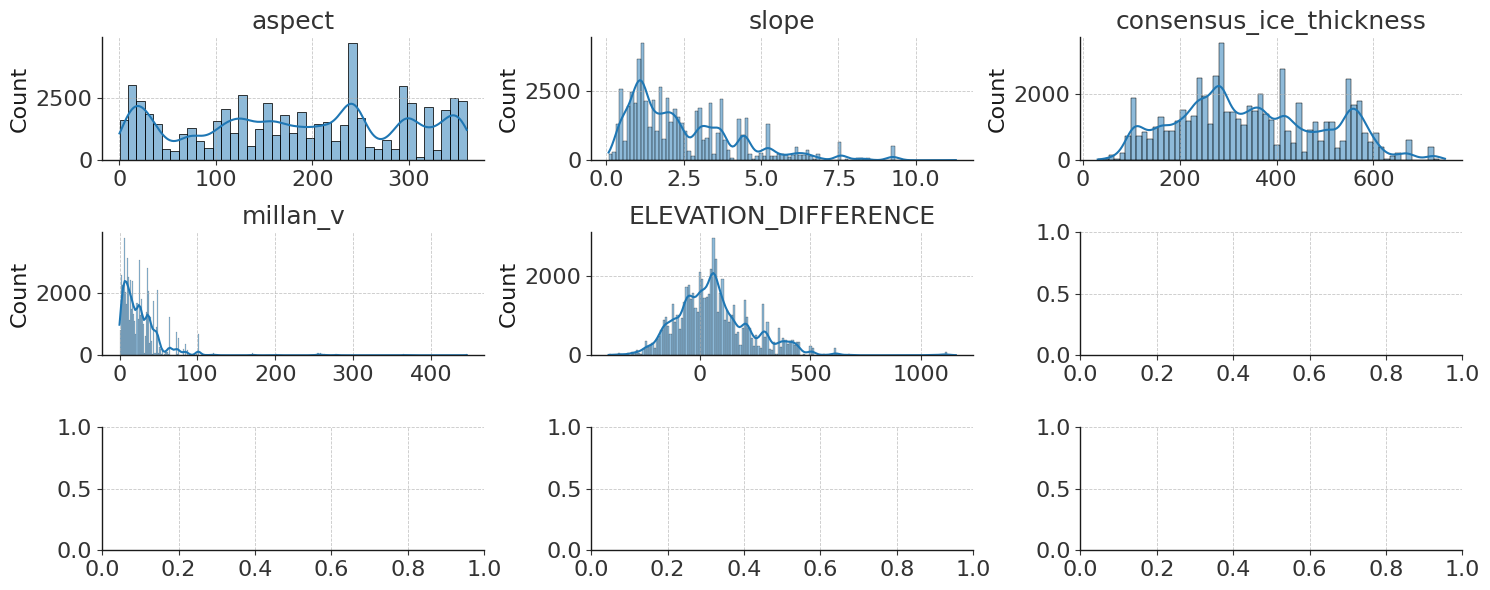

In [5]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

In [ ]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'Breidamerkurjoekull') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

### A.3. Train-test set split:

###### Either run A.3.1. or A.3.2.

##### A.3.1. Spatial Cross-Validation

###### Uses specific glaciers as test set

In [5]:
# These are the two icecaps to the west
Langjokul = dataloader_gl.data[
    (dataloader_gl.data['POINT_LON'] < -19.4) & 
    (dataloader_gl.data['POINT_LAT'] > 64.3)
]['GLACIER'].unique()
display(Langjokul)

array(['Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap',
       'RGI60-06.00302', 'Hagafellsjoekull East (Langjoekull S Dome)',
       'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00301',
       'RGI60-06.00311', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296'], dtype=object)

In [6]:
test_glaciers = ['Hagafellsjoekull West', 'RGI60-06.00303', 'Langjoekull Ice Cap',
       'RGI60-06.00302', 'Hagafellsjoekull East (Langjoekull S Dome)',
       'RGI60-06.00294', 'RGI60-06.00292', 'RGI60-06.00301',
       'RGI60-06.00311', 'RGI60-06.00305', 'RGI60-06.00306',
       'RGI60-06.00296']

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 11419
Size of train data: 50663
Percentage of test size: 22.54%
Train glaciers: (37) ['Thjorsarjoekull (Hofsjoekull E)' 'Sidujoekull/Skaftarjoekull'
 'Breidamerkurjoekull' 'Dyngjujoekull' 'RGI60-06.00328' 'Tungnaarjoekull'
 'Eyjabakkajoekull' 'Koeldukvislarjoekull' 'Oeldufellsjoekull'
 'Skeidararjoekull' 'Slettjoekull West' 'RGI60-06.00466' 'RGI60-06.00411'
 'RGI60-06.00359' 'RGI60-06.00340' 'Bruarjoekull'
 'Blagnipujoekull (Hofsjoekull SW)' 'RGI60-06.00238' 'RGI60-06.00320'
 'Sylgjujoekull' 'RGI60-06.00342' 'RGI60-06.00480' 'RGI60-06.00465'
 'RGI60-06.00232' 'RGI60-06.00478' 'Mulajoekull' 'RGI60-06.00413'
 'RGI60-06.00350' 'RGI60-06.00476' 'RGI60-06.00228' 'RGI60-06.00409'
 'RGI60-06.00349' 'RGI60-06.00422' 'RGI60-06.00425' 'RGI60-06.00479'
 'RGI60-06.00445' 'RGI60-06.00474']
Test glaciers: (12) ['Hagafellsjoekull West' 'RGI60-06.00303' 'Langjoekull Ice Cap'
 'RGI60-06.00302' 'Hagafellsjoekull East (Langjoekull S Dome)'
 'RGI60-06.00294' 'RGI60-06.00292' 'RGI60-06.0

##### A.3.2. Temporal Cross-Validation

###### Uses the last X years as test set

In [ ]:
test_years_count = 10

all_years = sorted(dataloader_gl.data['YEAR'].unique())

# Use the most recent years as test data
train_years = all_years[:-test_years_count]
test_years = all_years[-test_years_count:]

# Statistics prints
print('Size of test data:', len(test_years))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_years)]
print('Size of train data:', len(train_years))
if len(train_years) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(test_years) / len(train_years)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(
                                dataloader_gl,
                                test_split_on='YEAR',
                                test_splits=test_years,
                                random_state=cfg.seed)


print('Train year: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test years: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

##### A.3.3. Train-Test set plots

In [7]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

plot_climate_glacier_elevations(test_glaciers, test_set)

#### A.4. XGBoost:

In [ ]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700, 800],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = 12

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "consensus_ice_thickness",
    "millan_v",
]

###### Grid search:

In [15]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_Iceland_reworked_17_06.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_Iceland_reworked_17_06.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (50663, 25)
Shape of testing dataset: (11419, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'consensus_ice_thickness', 'millan_v']
Best parameters:
 {'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.1}
Best score:
 -0.5243685369753559
Shape of the test: (11419, 14)
Overall score: 1.7902487882331355
CPU times: user 572 ms, sys: 29.3 ms, total: 602 ms
Wall time: 153 ms


learning_rate  max_depth  n_estimators  Validation rmse  Train rmse
Model                                                                     
1               0.10          6           500         0.524369    0.007648
2               0.10          6           400         0.527776    0.010580
3               0.10          5           700         0.539217    0.011899
4               0.10          6           200         0.545505    0.026698
5               0.10          5           400         0.552513    0.025087
6               0.01          8           500         0.570161    0.035072
7               0.10          8           700         0.613202    0.001584
8               0.01          6           300         0.614381    0.155080
9               0.01          5           300         0.636244    0.264247
10              0.10          7           700         0.649838    0.002147

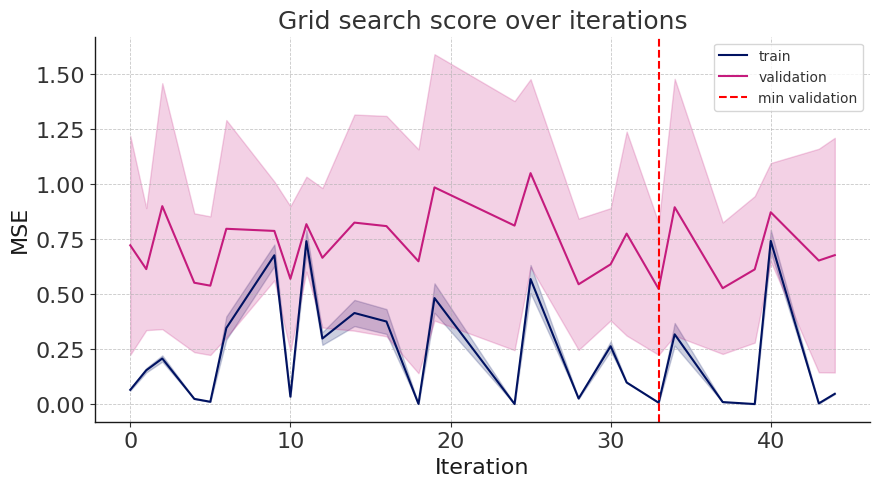

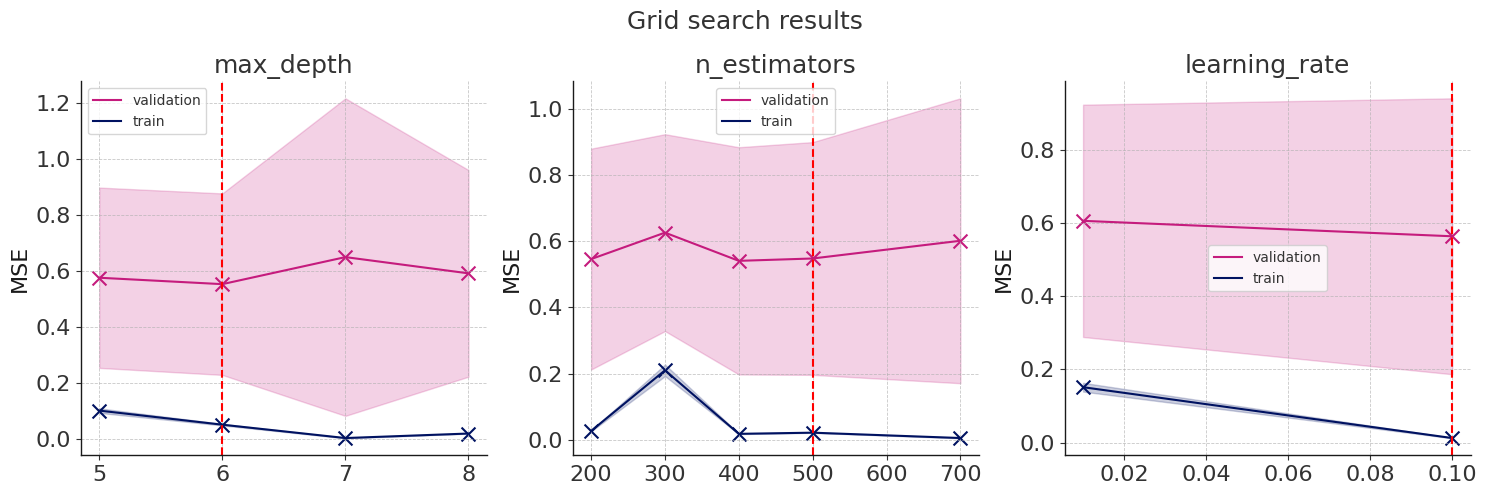

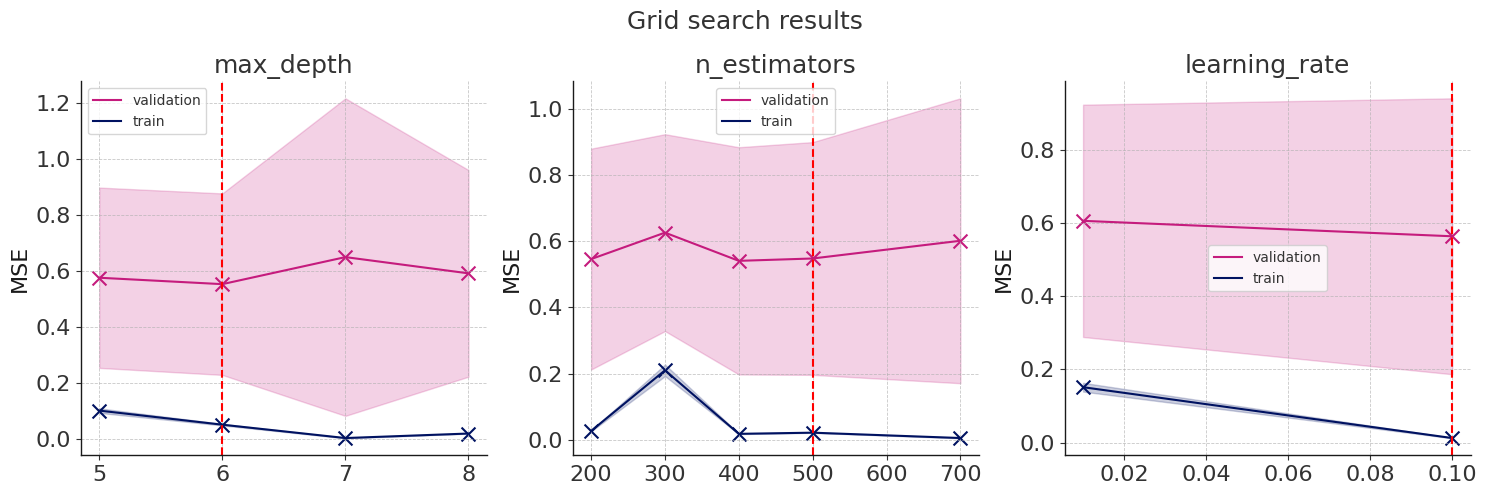

In [16]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

print_top_n_models(custom_xgboost.param_search.cv_results_)

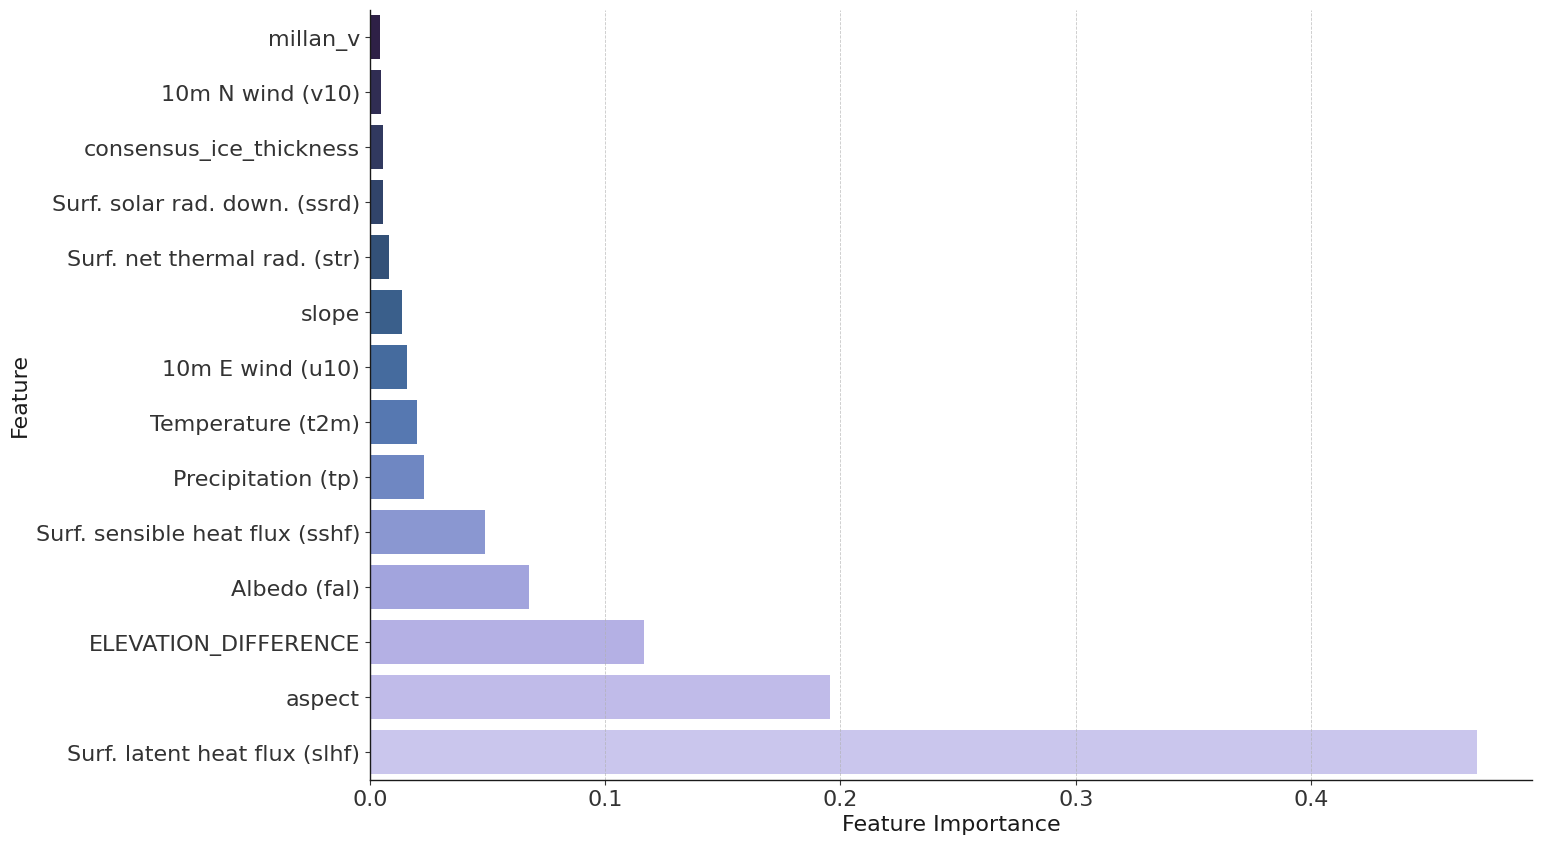

In [17]:
FIPlot(best_estimator, feature_columns, vois_climate)

###### Predictions of best parameters:

Shape of the test: (11419, 14)


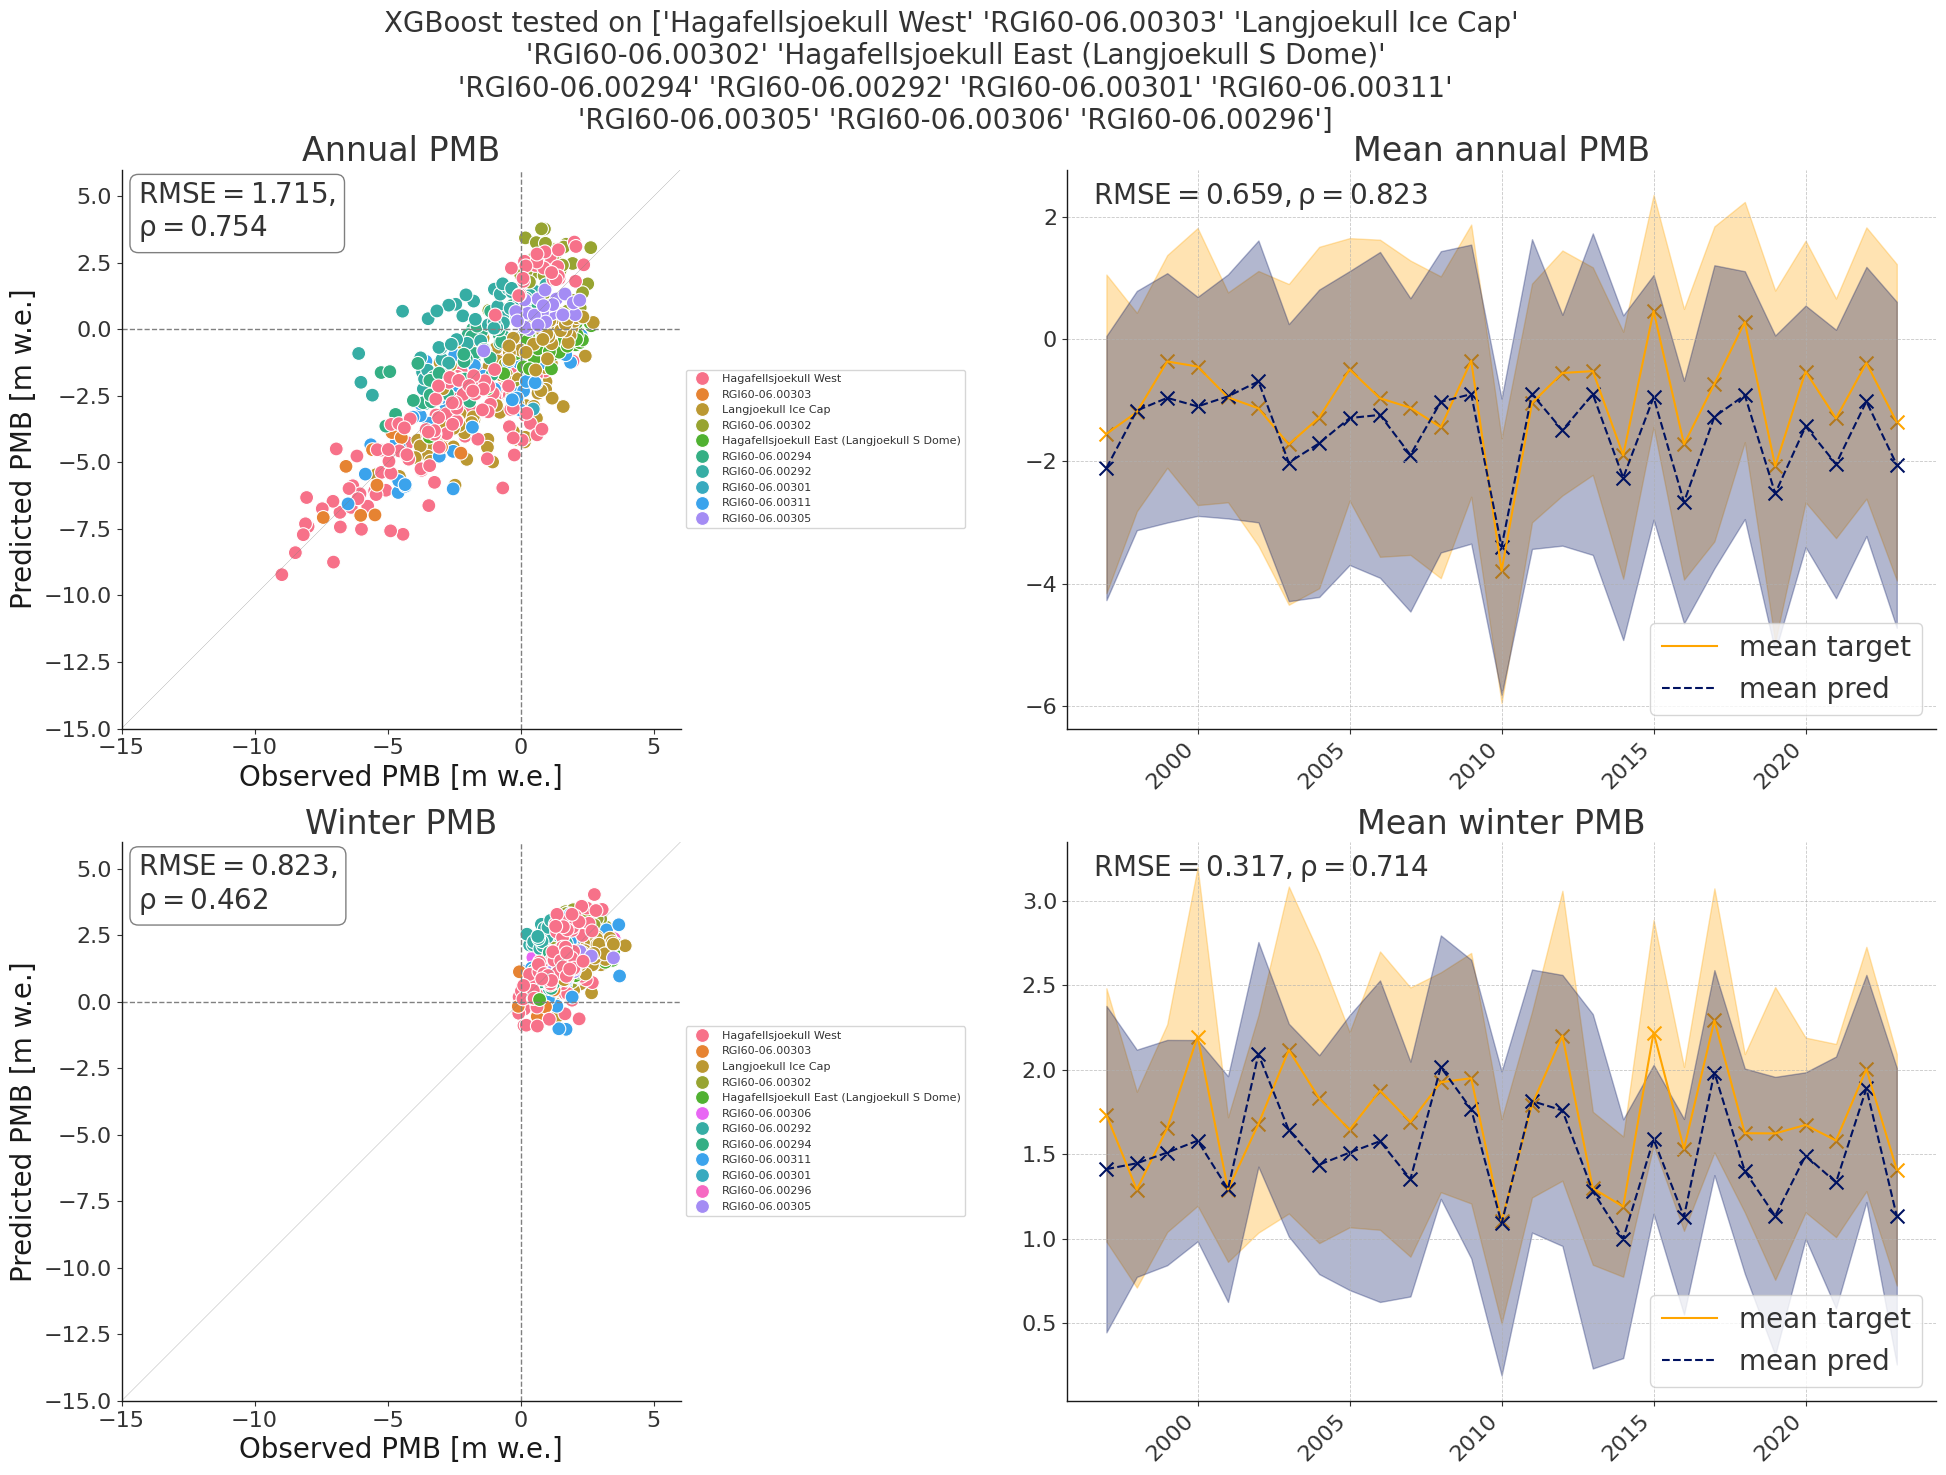

In [18]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, include_summer=False)
plt.suptitle(f'XGBoost tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

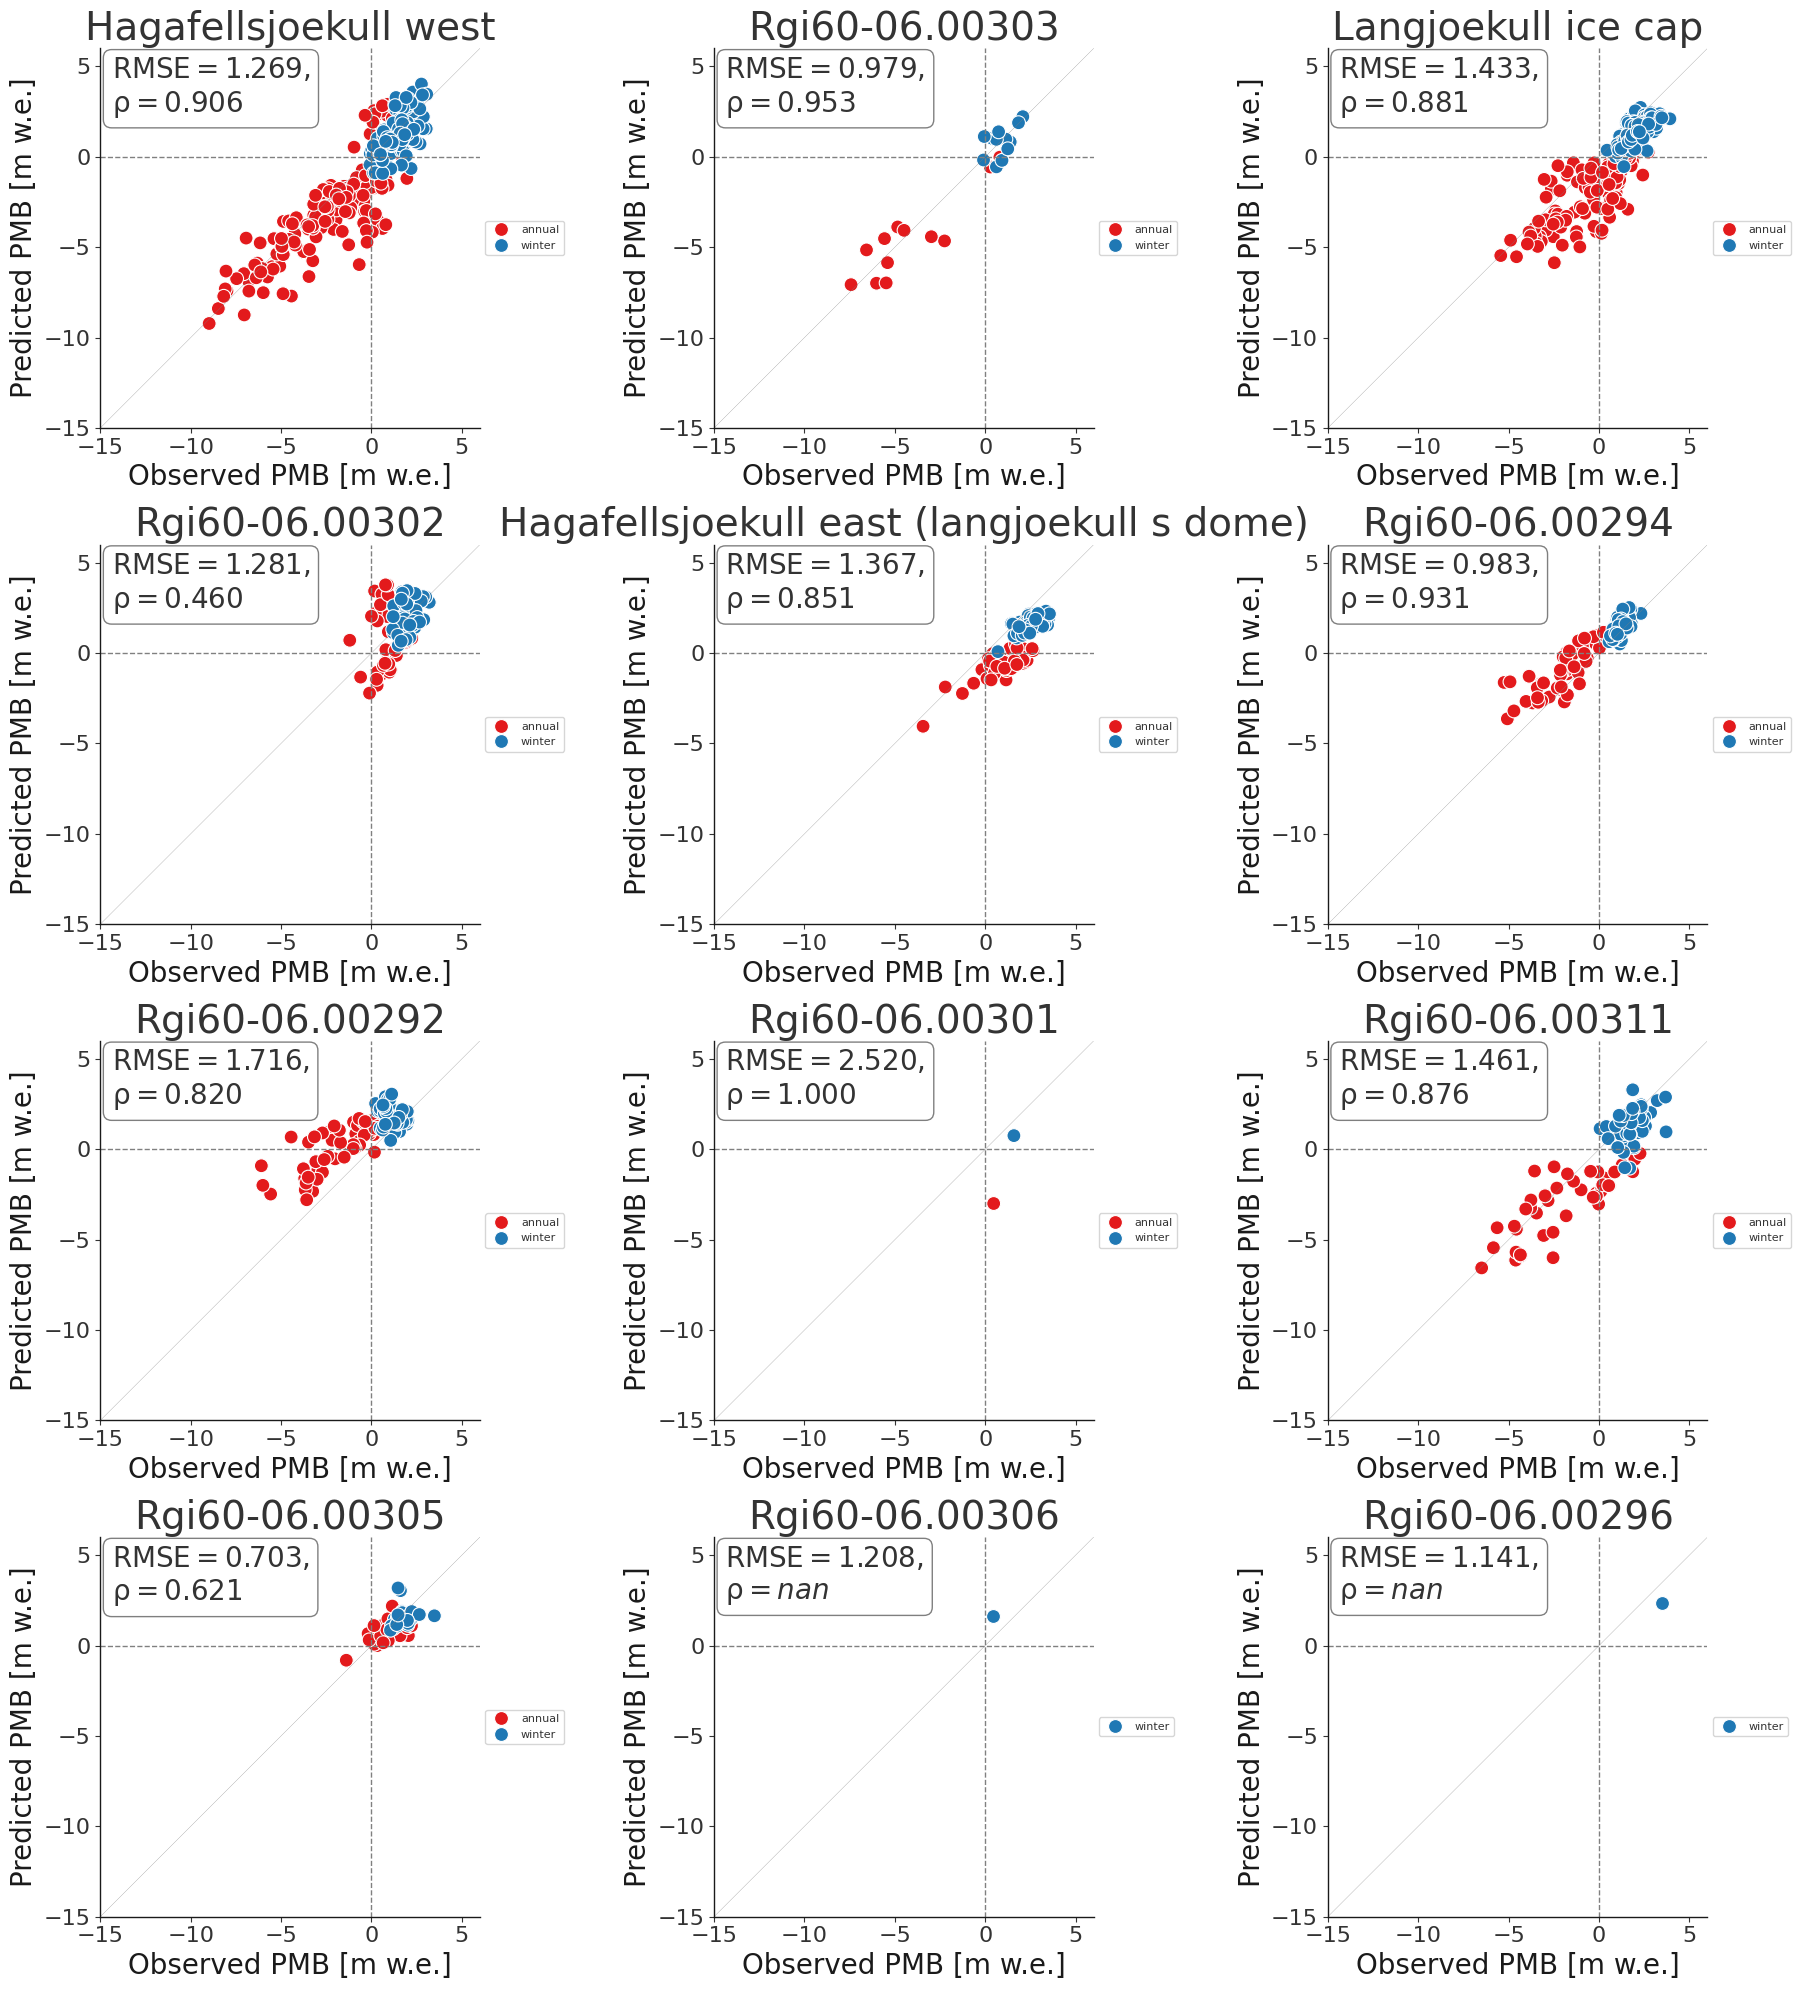

In [19]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

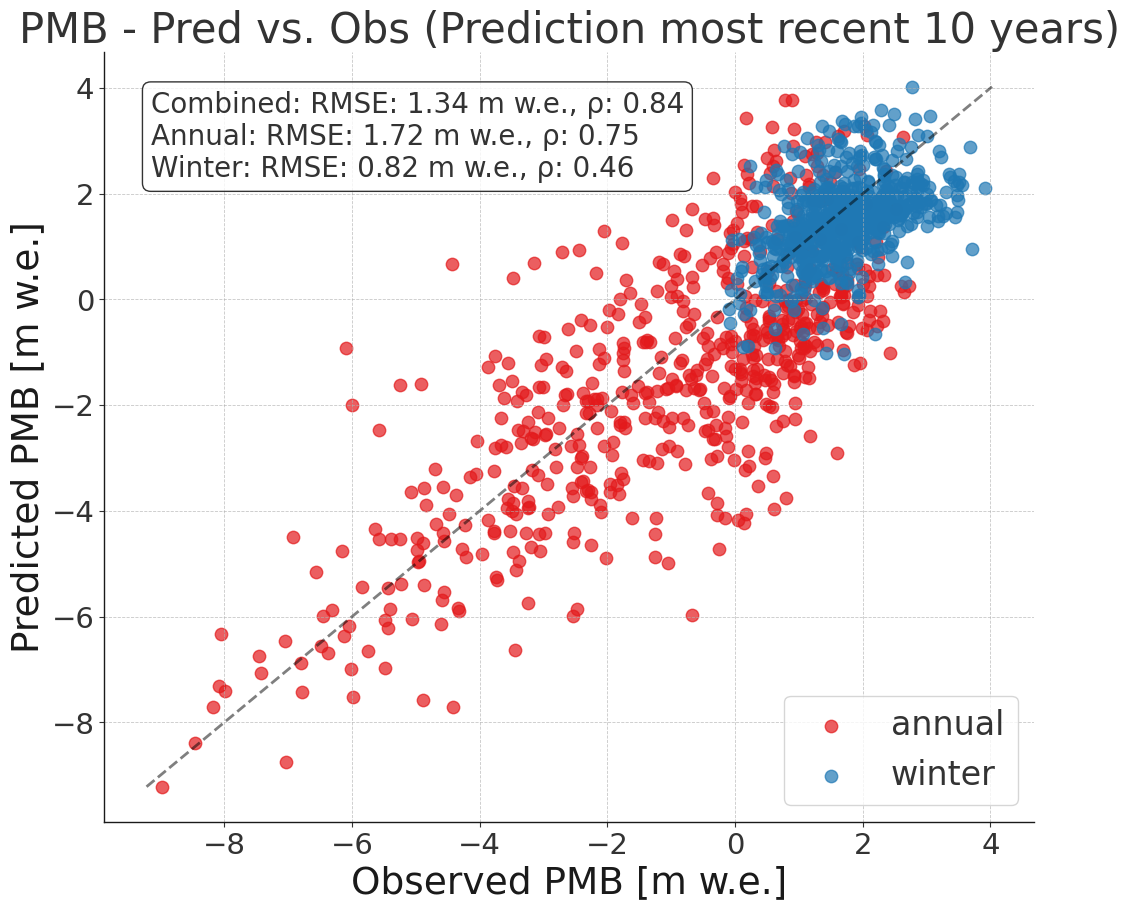

In [20]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='Prediction most recent 10 years', include_summer = False)

target    YEAR                                 POINT_ID  \
ID                                                                
702   1.594000  2015.0    Langjoekull Ice Cap_2015.0_annual_L14   
706   0.137500  2019.0    Langjoekull Ice Cap_2019.0_annual_L14   
710   0.170000  2023.0    Langjoekull Ice Cap_2023.0_annual_L14   
1626  0.610500  2015.0  Hagafellsjoekull West_2015.0_annual_L10   
1628  0.050375  2017.0  Hagafellsjoekull West_2017.0_annual_L10   
1629  0.795000  2018.0  Hagafellsjoekull West_2018.0_annual_L10   
1630 -0.677500  2019.0  Hagafellsjoekull West_2019.0_annual_L10   
1633 -0.245000  2023.0  Hagafellsjoekull West_2023.0_annual_L10   

                    GLACIER      pred  PERIOD  pmb_diff  
ID                                                       
702     Langjoekull Ice Cap -2.903087  annual  4.497087  
706     Langjoekull Ice Cap -4.233252  annual  4.370752  
710     Langjoekull Ice Cap -4.058875  annual  4.228875  
1626  Hagafellsjoekull West -3.966824  annual  4.577324  
1628  Hagafellsjoekull West -4.165310  annual  4.215685  
1629  Hagafellsjoekull West -3.754414  annual  4.549414  
1630  Hagafellsjoekull West -5.962664  annual  5.285164  
1633  Hagafellsjoekull West -4.724157  annual  4.479157

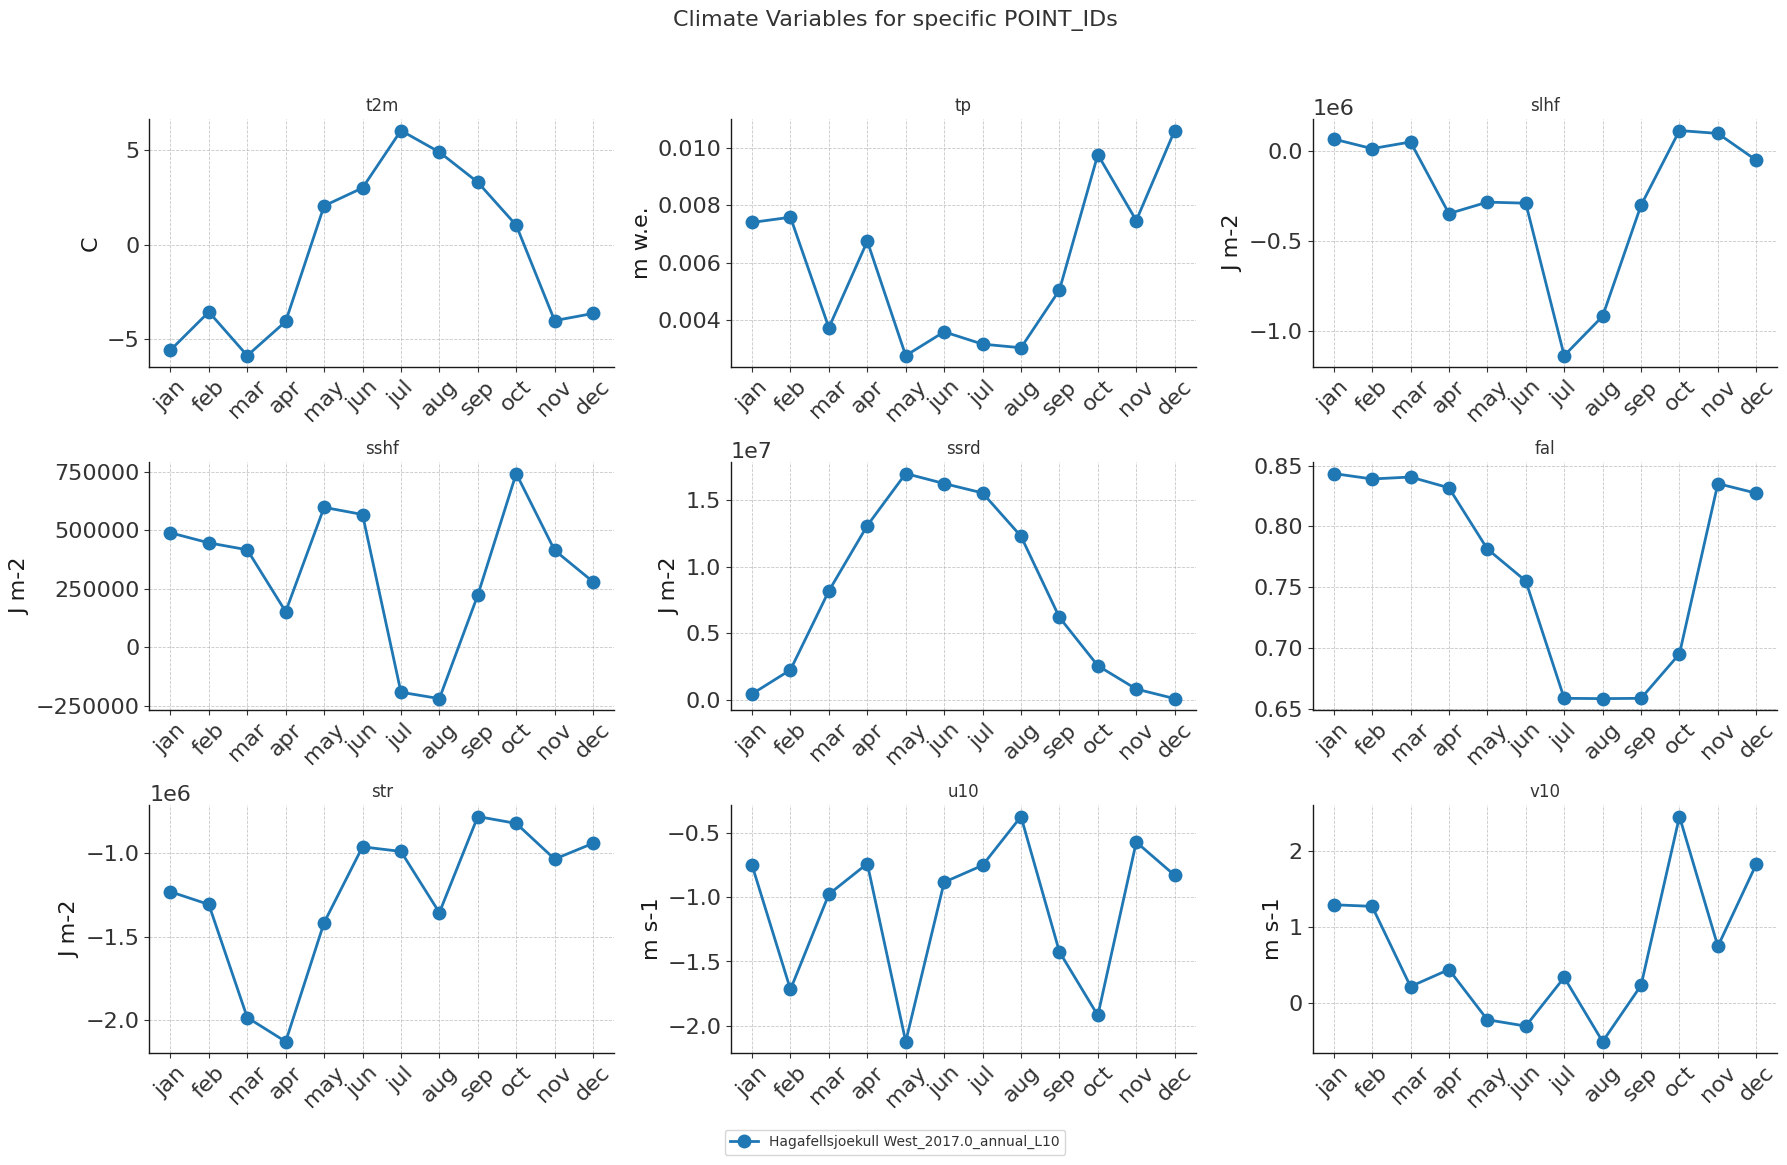

In [22]:
# Search for points with large prediction errors
grouped_ids_test = grouped_ids.copy()
grouped_ids_test['pmb_diff'] = grouped_ids_test['target'] - grouped_ids_test['pred']
pd.set_option('display.max_colwidth', None) 
display(grouped_ids_test[abs(grouped_ids_test['pmb_diff'] > 4)
])
pd.reset_option('display.max_colwidth')

# Plot climate variables for specific points
point_ids = ['Hagafellsjoekull West_2017.0_annual_L10']

plot_point_climate_variables(
    point_ids=point_ids,
    data_monthly=data_monthly,
    vois_climate=vois_climate,
    vois_units=vois_units
)

### B.1. Train CH Test ICE

In [14]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_ICE = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/ICE_dataset_all_oggm.csv')

display(data_CH.columns)

display(data_ICE.columns)

data_CH = data_CH.drop(['hugonnet_dhdt', 'aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with ICE
data_ICE_CH = pd.concat([data_ICE, data_CH], axis=0).reset_index(drop=True)

display(data_ICE_CH.head(2))

display(len(data_ICE_CH['GLACIER'].unique()))

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_ELEVATION', 'POINT_LAT', 'POINT_LON', 'DATA_MODIFICATION',
       'FROM_DATE', 'TO_DATE', 'POINT_BALANCE', 'PERIOD', 'YEAR', 'RGIId',
       'aspect', 'slope', 'topo', 'consensus_ice_thickness', 'millan_v',
       'GLACIER', 'POINT_ID'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

POINT_ELEVATION  POINT_LAT  POINT_LON DATA_MODIFICATION  FROM_DATE  \
0           1049.6  64.790063 -18.595688               NaN   19880920   
1           1049.4  64.790063 -18.595688               NaN   19890922   

    TO_DATE  POINT_BALANCE  PERIOD    YEAR           RGIId     aspect  \
0  19890922           0.45  annual  1989.0  RGI60-06.00234  158.07156   
1  19900916          -0.80  annual  1990.0  RGI60-06.00234  158.07156   

      slope         topo  consensus_ice_thickness   millan_v  \
0  2.508572  1034.505493               270.877716  25.446609   
1  2.508572  1034.505493               270.877716  25.446609   

                           GLACIER  \
0  Thjorsarjoekull (Hofsjoekull E)   
1  Thjorsarjoekull (Hofsjoekull E)   

                                            POINT_ID  
0  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...  
1  Thjorsarjoekull (Hofsjoekull E)_1990.0_annual_...

88

###### Add ERA5Land data to the combined CH_ICE stakes

In [15]:
data_CH_ICE_test = data_ICE_CH.copy()

display(data_CH_ICE_test.shape)
display(data_CH_ICE_test.head(2))

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_ICECH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_ICECH.nc'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_ICE_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_ICE_wgms_dataset_monthly_full.csv')
data_monthly_CH_ICE = dataloader_gl.data

display(data_monthly_CH_ICE.head(2))

(39904, 17)

POINT_ELEVATION  POINT_LAT  POINT_LON DATA_MODIFICATION  FROM_DATE  \
0           1049.6  64.790063 -18.595688               NaN   19880920   
1           1049.4  64.790063 -18.595688               NaN   19890922   

    TO_DATE  POINT_BALANCE  PERIOD    YEAR           RGIId     aspect  \
0  19890922           0.45  annual  1989.0  RGI60-06.00234  158.07156   
1  19900916          -0.80  annual  1990.0  RGI60-06.00234  158.07156   

      slope         topo  consensus_ice_thickness   millan_v  \
0  2.508572  1034.505493               270.877716  25.446609   
1  2.508572  1034.505493               270.877716  25.446609   

                           GLACIER  \
0  Thjorsarjoekull (Hofsjoekull E)   
1  Thjorsarjoekull (Hofsjoekull E)   

                                            POINT_ID  
0  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...  
1  Thjorsarjoekull (Hofsjoekull E)_1990.0_annual_...

2025-06-17 12:44:08,171 - INFO - Number of annual and seasonal samples: 39904
2025-06-17 12:44:08,174 - INFO - Running on 88 glaciers:
['Thjorsarjoekull (Hofsjoekull E)' 'Sidujoekull/Skaftarjoekull'
 'Breidamerkurjoekull' 'Dyngjujoekull' 'RGI60-06.00328' 'Tungnaarjoekull'
 'Hagafellsjoekull West' 'Eyjabakkajoekull' 'RGI60-06.00303'
 'Langjoekull Ice Cap' 'Koeldukvislarjoekull' 'Oeldufellsjoekull'
 'Skeidararjoekull' 'Slettjoekull West' 'RGI60-06.00466' 'RGI60-06.00411'
 'RGI60-06.00302' 'RGI60-06.00359' 'RGI60-06.00340' 'Bruarjoekull'
 'Blagnipujoekull (Hofsjoekull SW)' 'RGI60-06.00238' 'RGI60-06.00320'
 'Sylgjujoekull' 'Hagafellsjoekull East (Langjoekull S Dome)'
 'RGI60-06.00342' 'RGI60-06.00480' 'RGI60-06.00465' 'RGI60-06.00294'
 'RGI60-06.00292' 'RGI60-06.00232' 'RGI60-06.00478' 'Mulajoekull'
 'RGI60-06.00301' 'RGI60-06.00413' 'RGI60-06.00311' 'RGI60-06.00350'
 'RGI60-06.00476' 'RGI60-06.00228' 'RGI60-06.00409' 'RGI60-06.00349'
 'RGI60-06.00422' 'RGI60-06.00305' 'RGI60-06.00425' 'R

2025-06-17 12:44:32,584 - INFO - Converting to monthly resolution...
2025-06-17 12:46:01,497 - INFO - Number of monthly rows: 352764
2025-06-17 12:46:01,500 - INFO - Columns in the dataset: Index(['YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE', 'ALTITUDE_CLIMATE',
       'ELEVATION_DIFFERENCE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
       'N_MONTHS', 'MONTHS', 'PERIOD', 'GLACIER', 'aspect', 'slope',
       'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf',
       'ssrd', 'fal', 'str', 'u10', 'v10'],
      dtype='object')
2025-06-17 12:46:09,043 - INFO - Processed data saved to: /home/mburlet/scratch/data/DATA_MB/WGMS/Iceland/csv/CH_ICE_wgms_dataset_monthly_full.csv


YEAR  POINT_LON  POINT_LAT  POINT_BALANCE  ALTITUDE_CLIMATE  \
0  1989.0 -18.595688  64.790063           0.45       1094.738918   
1  1989.0 -18.595688  64.790063           0.45       1094.738918   

   ELEVATION_DIFFERENCE  POINT_ELEVATION           RGIId  \
0            -45.138918           1049.6  RGI60-06.00234   
1            -45.138918           1049.6  RGI60-06.00234   

                                            POINT_ID  ID  ...   millan_v  \
0  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...   0  ...  25.446609   
1  Thjorsarjoekull (Hofsjoekull E)_1989.0_annual_...   0  ...  25.446609   

        t2m        tp      slhf      sshf       ssrd      fal        str  \
0 -4.787933  0.003747  198886.0  590722.0  3990646.0  0.84564 -1779436.0   
1 -5.262054  0.003766  306376.0  576896.0   883468.0  0.84690 -1458576.0   

        u10       v10  
0 -0.590102  0.603381  
1  0.129348  2.214950  

[2 rows x 27 columns]

###### Test and Train set

In [16]:
test_glaciers = list(data_ICE['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers correctly
train_glaciers = list(data_CH['GLACIER'].unique())

data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

Size of test data: 62082
Size of train data: 290682
Percentage of test size: 21.36%
Train glaciers: (39) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen'
 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro'
 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel'
 'oberaar' 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'sardona' 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta'
 'taelliboden' 'tiefen' 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
Test glaciers: (49) ['Thjorsarjoekull (Hofsjoekull E)' 'Sidujoekull/Skaftarjoekull'
 'Breidamerkurjoekull' 'Dyngjujoekull' 'RGI60-06.00328' 'Tungnaarjoekull'
 'Hagafellsjoekull West' 'Eyjabakkajoekull' 'RGI60-06.00303'
 'Langjoekull Ice Cap' 'Koeldukvislarjoekull' 'Oeldufellsjoekull'
 'Skeidararjoekull' 'Slettjoekull West' 'RGI60-06.00466' 'RGI60-06.00411'
 'RGI60-06.00302' 'RGI60-06.00359' 'RGI60-06.00340' 'Bruarjoekull'
 'Blagnipujoekull (Hofsjoekull SW)' 'RGI60-06.00

##### B.2. Train-Test set plots

In [ ]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

plot_climate_glacier_elevations(test_glaciers, test_set)

#### B.4. XGBoost

In [17]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'gpu_hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    #"hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

#### Grid Search

In [18]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_CH_train_ICE_test_11_06.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_CH_train_ICE_test_11_06.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

Shape of training dataset: (290682, 25)
Shape of testing dataset: (62082, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'consensus_ice_thickness', 'millan_v']
Best parameters:
 {'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}
Best score:
 -0.19564066187781454
Shape of the test: (62082, 14)
Overall score: 4.758895797991278
CPU times: user 393 ms, sys: 98.2 ms, total: 492 ms
Wall time: 291 ms


learning_rate  max_depth  n_estimators  Validation rmse  Train rmse
Model                                                                     
1               0.01          8           500         0.195641    0.069807
2               0.10          4           500         0.224590    0.095226
3               0.10          5           700         0.228131    0.039806
4               0.10          5           400         0.229613    0.063237
5               0.01          6           300         0.231706    0.181977
6               0.10          6           500         0.232044    0.025933
7               0.10          6           400         0.232145    0.033372
8               0.10          6           200         0.234023    0.062396
9               0.10          7           400         0.240007    0.015594
10              0.10          7           700         0.240884    0.006142

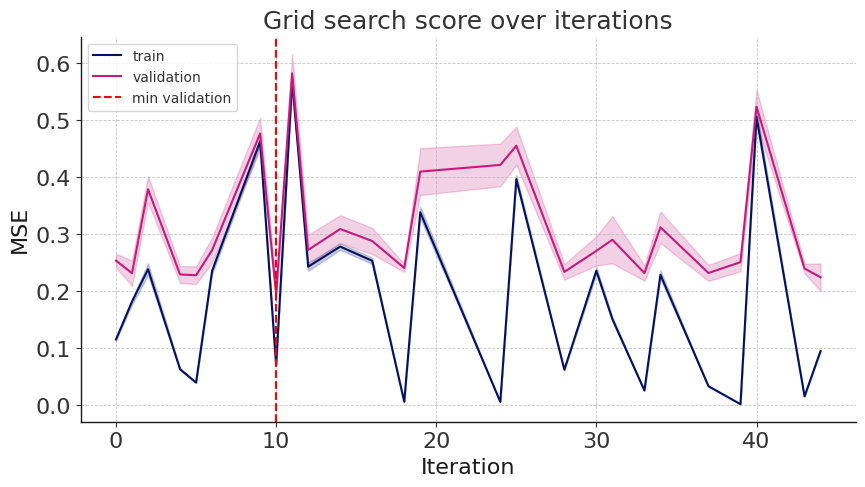

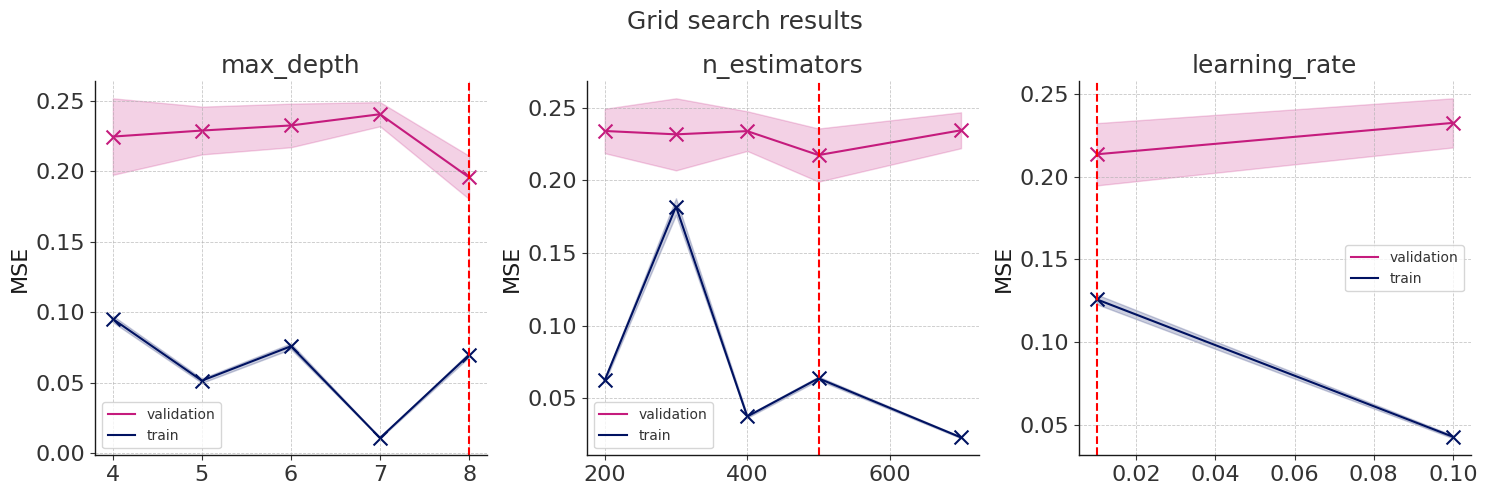

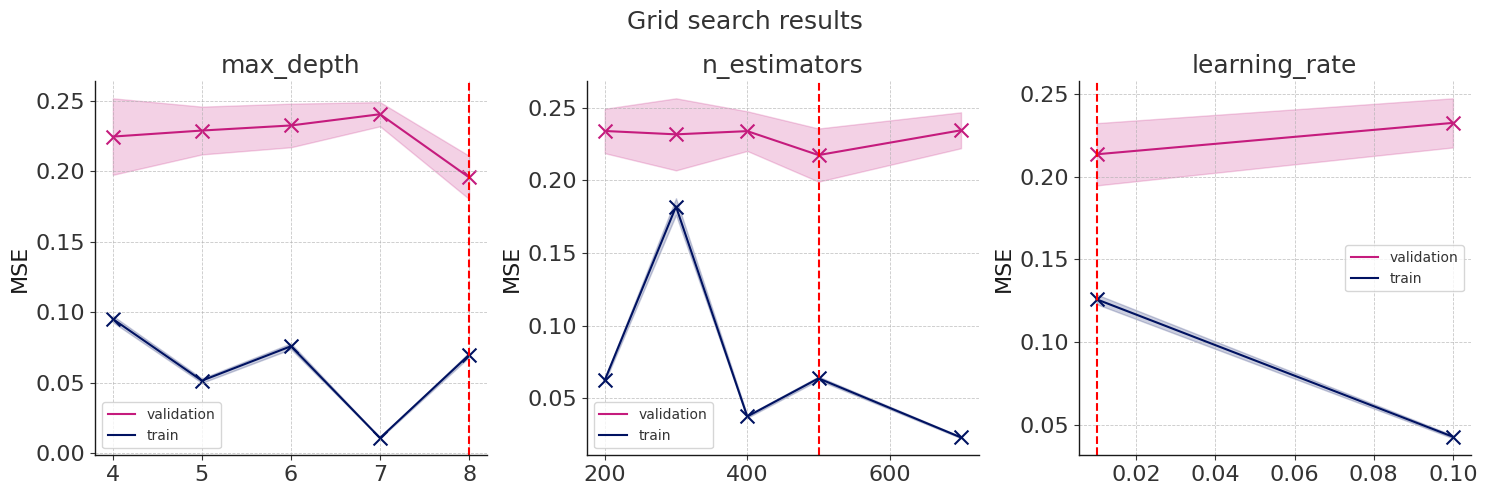

In [19]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

print_top_n_models(custom_xgboost.param_search.cv_results_)

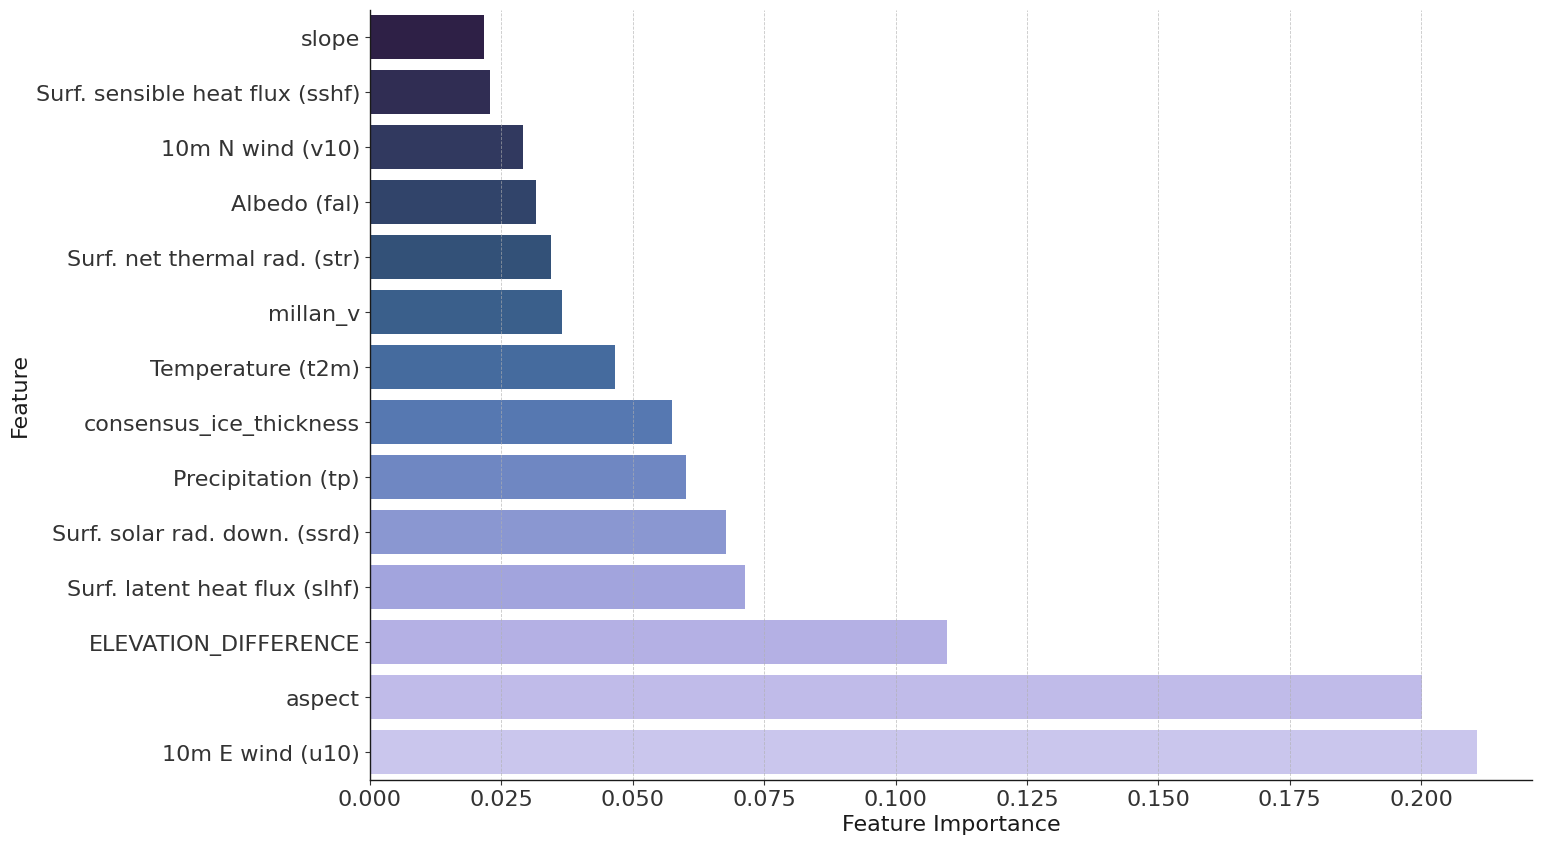

In [20]:
FIPlot(best_estimator, feature_columns, vois_climate)

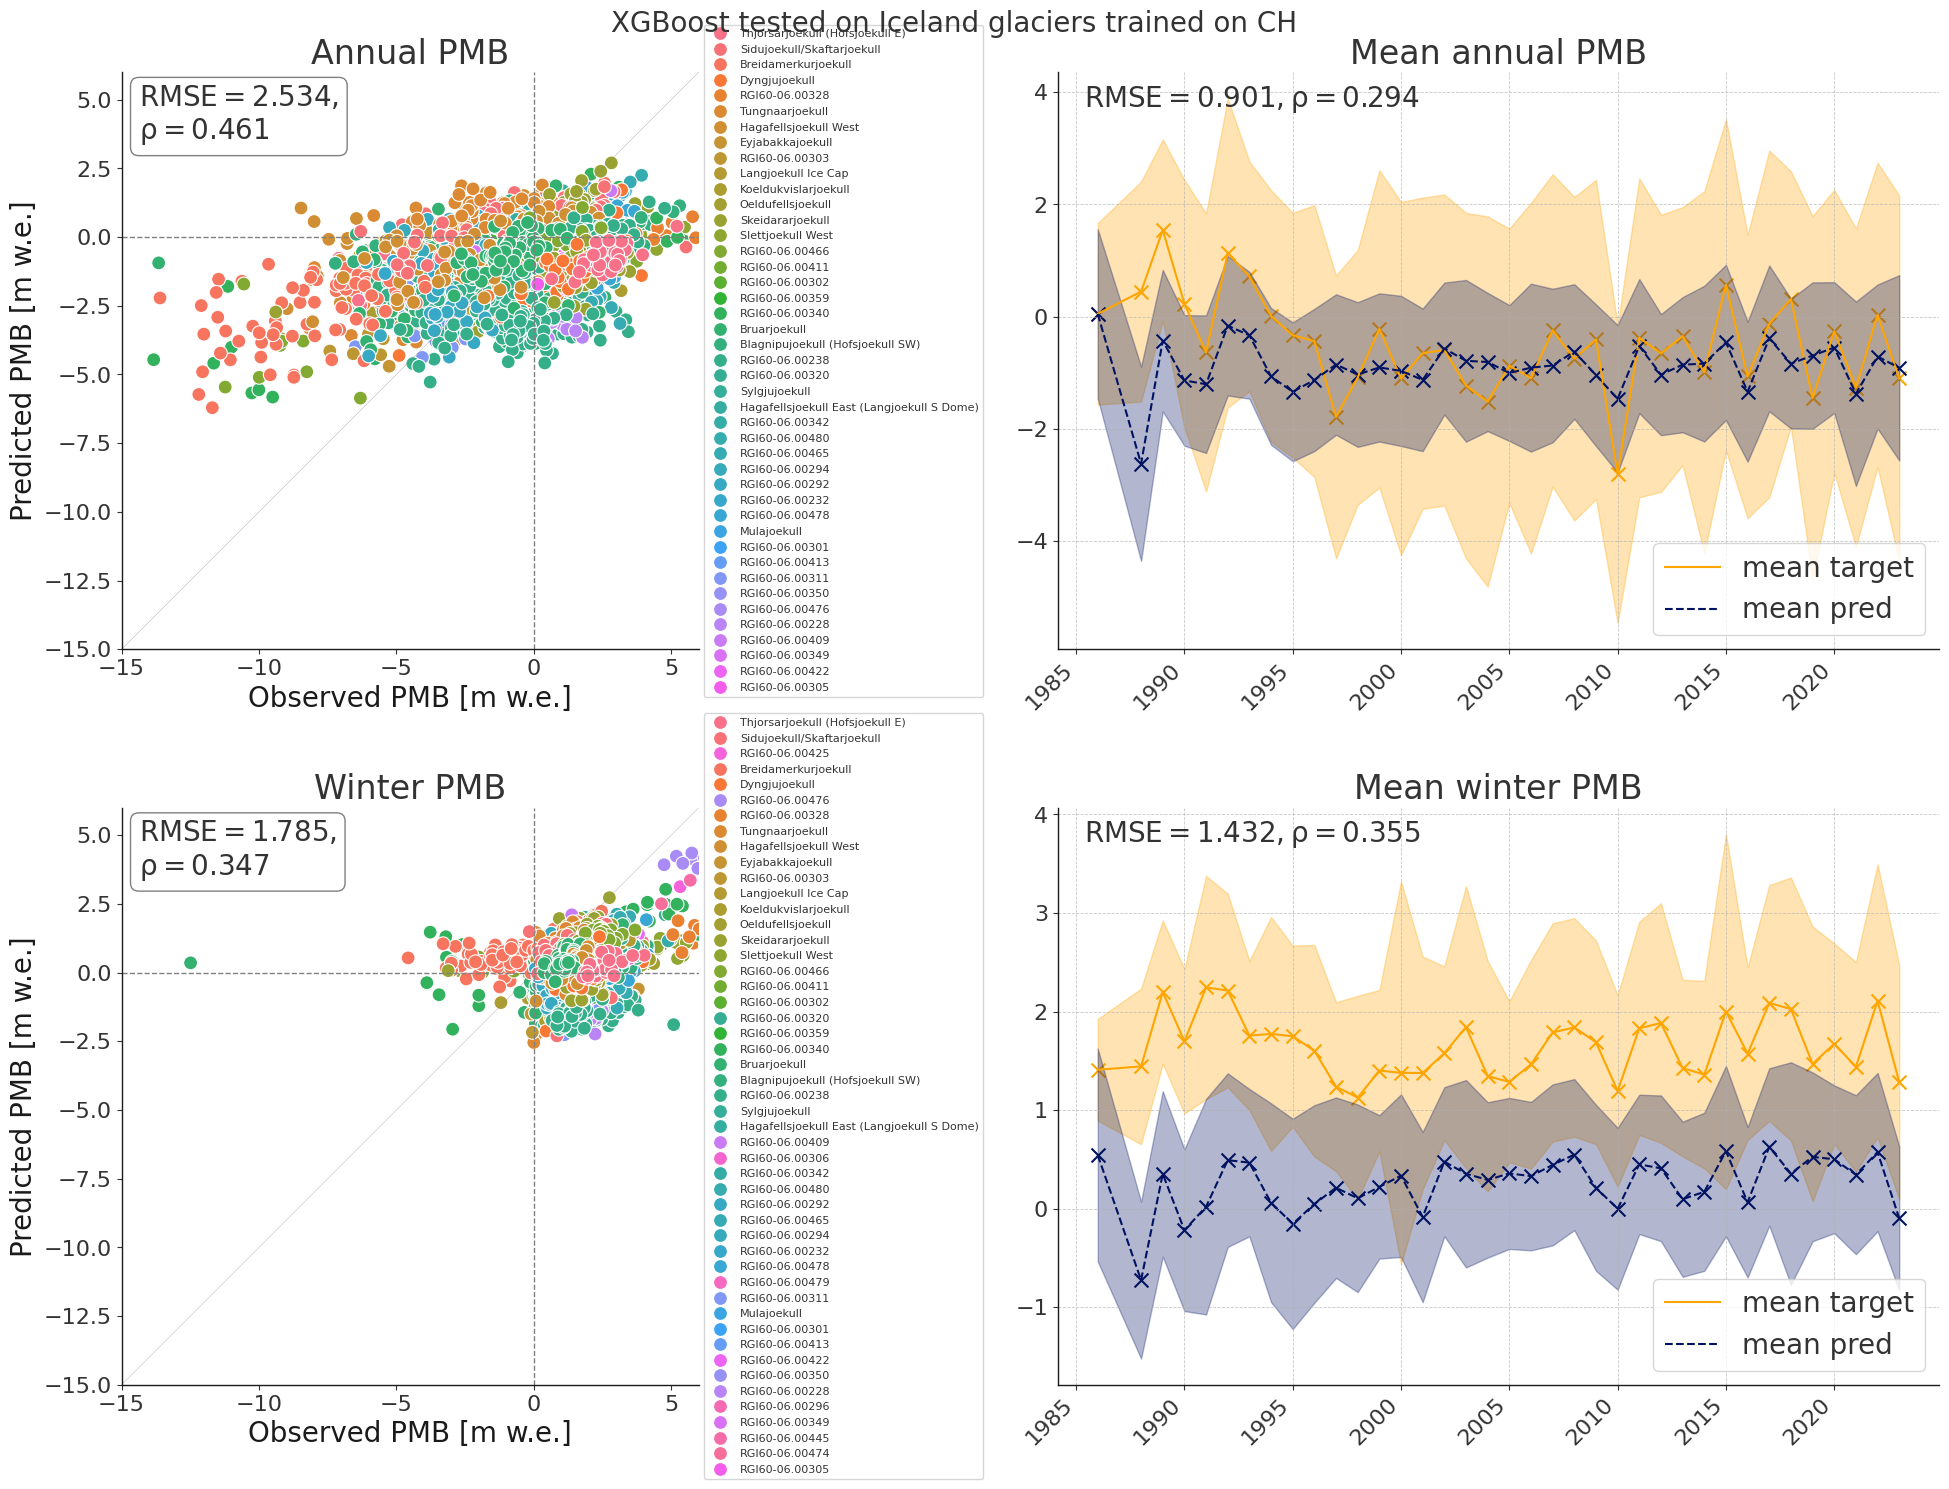

In [21]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)

PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on Iceland glaciers trained on CH', fontsize=20)
plt.tight_layout()

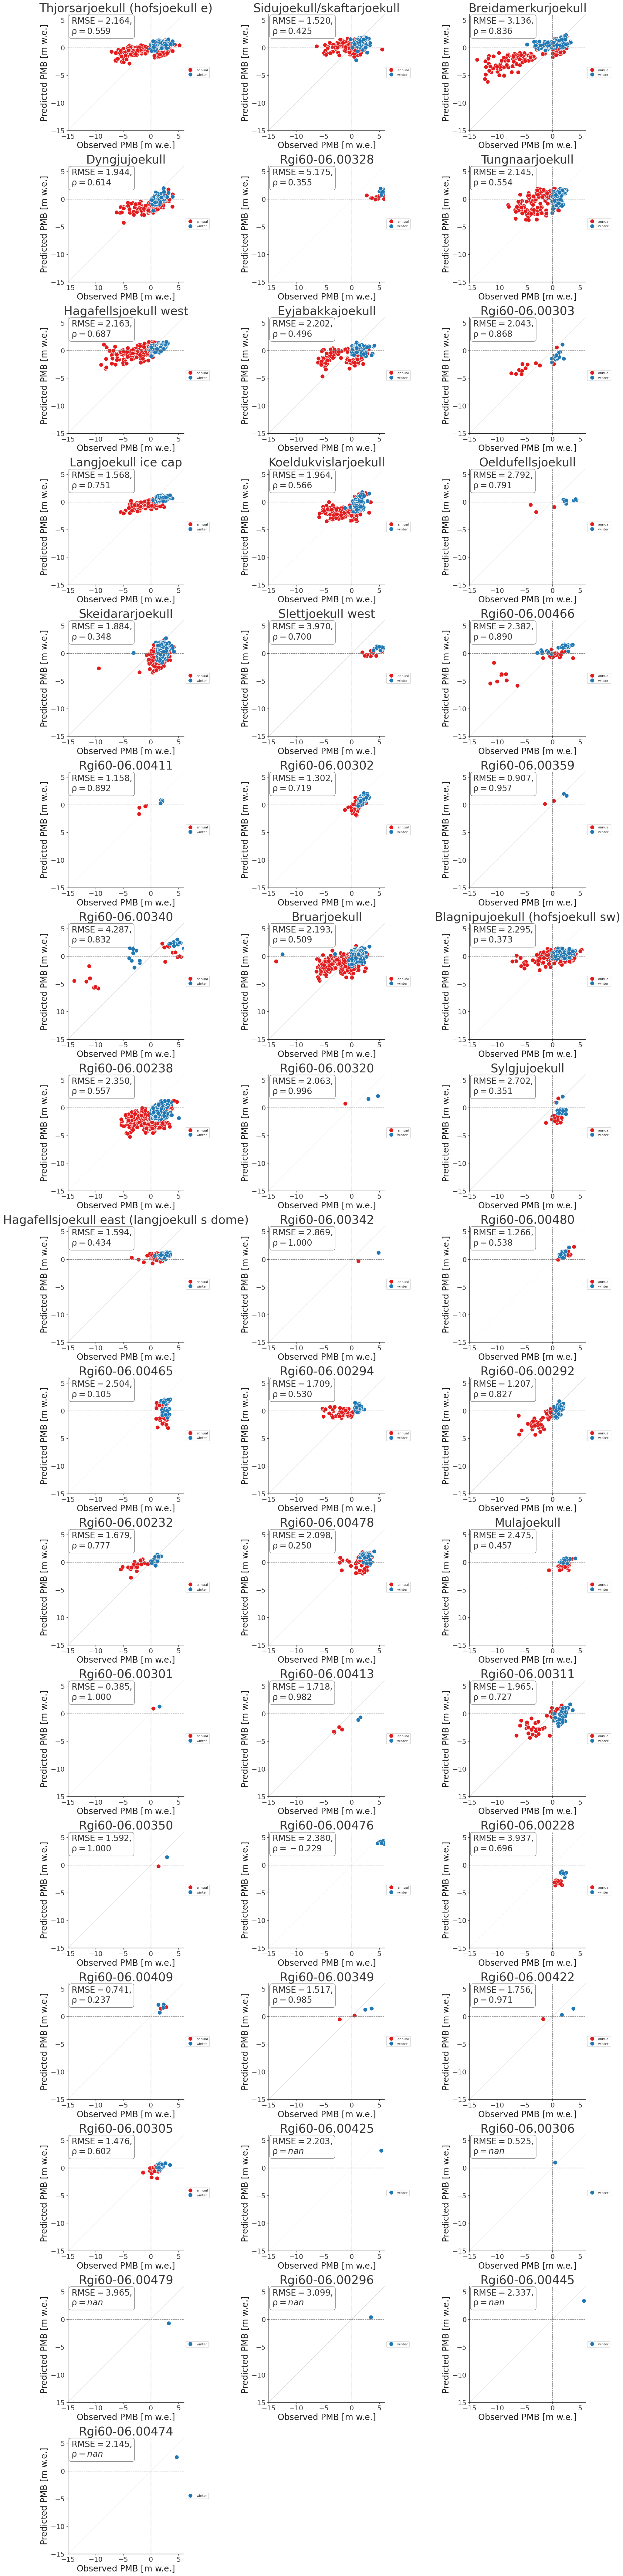

In [22]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

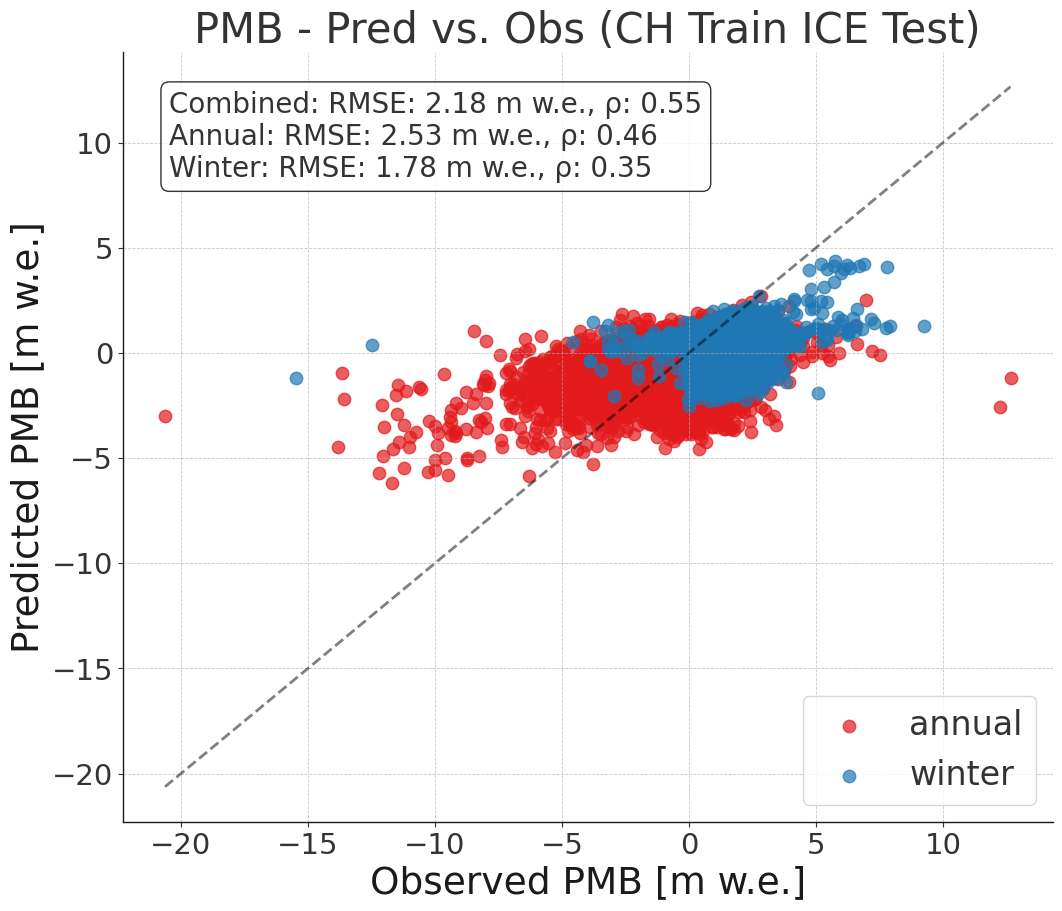

In [23]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='CH Train ICE Test', include_summer = False)

target    YEAR                                       POINT_ID  \
ID                                                                     
119    3.1780  1995.0         Koeldukvislarjoekull_1995.0_annual_K04   
245    5.4840  2017.0           Slettjoekull West_2017.0_annual_Mst2   
350    3.9200  1992.0             Dyngjujoekull_1992.0_annual_D05-92   
382    6.5160  2017.0              RGI60-06.00340_2017.0_annual_Mst3   
386    5.4600  2022.0              RGI60-06.00340_2022.0_annual_Mst3   
890    5.5400  1992.0  Sidujoekull/Skaftarjoekull_1992.0_annual_Si08   
1114   5.8930  2001.0              RGI60-06.00328_2001.0_annual_Mst1   
1115   4.8530  2008.0              RGI60-06.00340_2008.0_annual_Mst1   
1118   5.2270  2013.0              RGI60-06.00340_2013.0_annual_Mst1   
1119   7.1860  2015.0              RGI60-06.00328_2015.0_annual_Mst1   
1121   6.6080  2017.0              RGI60-06.00328_2017.0_annual_Mst1   
1122   5.7781  2018.0              RGI60-06.00328_2018.0_annual_Mst1   
1126   7.5100  2022.0              RGI60-06.00328_2022.0_annual_Mst1   
1215   1.6100  1990.0              RGI60-06.00238_1990.0_annual_hn15   
1217   2.9900  1993.0              RGI60-06.00238_1993.0_annual_hn15   
1218   1.9400  1994.0              RGI60-06.00238_1994.0_annual_hn15   
1219   1.5200  1995.0              RGI60-06.00238_1995.0_annual_hn15   
1220   1.4000  1996.0              RGI60-06.00238_1996.0_annual_hn15   
1225   1.3900  2001.0              RGI60-06.00238_2001.0_annual_hn15   
1233   1.7500  2009.0              RGI60-06.00238_2009.0_annual_hn15   
1236   3.3500  2012.0              RGI60-06.00238_2012.0_annual_hn15   
1239   3.4400  2015.0              RGI60-06.00238_2015.0_annual_hn15   
1242   2.3900  2018.0              RGI60-06.00238_2018.0_annual_hn15   
1246   2.4200  2022.0              RGI60-06.00238_2022.0_annual_hn15   
1247   1.6400  2023.0              RGI60-06.00238_2023.0_annual_hn15   
1299   3.1375  2017.0               RGI60-06.00465_2017.0_annual_B19   
1301   2.8240  2019.0               RGI60-06.00465_2019.0_annual_B19   
1636   2.3800  1993.0                 Bruarjoekull_1993.0_annual_B03   
1746   1.7700  2001.0            RGI60-06.00228_2001.0_annual_hn15aa   
1750  12.2425  1999.0                 Bruarjoekull_1999.0_annual_Bru   
3140  12.6520  2014.0                 Bruarjoekull_2014.0_annual_B12   
3449   6.2710  2015.0           Slettjoekull West_2015.0_winter_Mst2   
3451   6.2400  2017.0           Slettjoekull West_2017.0_winter_Mst2   
3456   6.2400  2022.0           Slettjoekull West_2022.0_winter_Mst2   
4361   6.7990  2001.0              RGI60-06.00328_2001.0_winter_Mst1   
4362   7.7570  2007.0              RGI60-06.00340_2007.0_winter_Mst1   
4363   6.2920  2008.0              RGI60-06.00340_2008.0_winter_Mst1   
4366   6.5400  2011.0              RGI60-06.00340_2011.0_winter_Mst1   
4367   6.5900  2012.0              RGI60-06.00328_2012.0_winter_Mst1   
4368   6.2700  2013.0              RGI60-06.00340_2013.0_winter_Mst1   
4369   7.8960  2015.0              RGI60-06.00328_2015.0_winter_Mst1   
4371   7.1600  2017.0              RGI60-06.00328_2017.0_winter_Mst1   
4372   7.2800  2018.0              RGI60-06.00328_2018.0_winter_Mst1   
4376   9.2600  2022.0              RGI60-06.00328_2022.0_winter_Mst1   
4470   5.0900  1991.0              RGI60-06.00238_1991.0_winter_hn15   
4494   3.8000  2015.0              RGI60-06.00238_2015.0_winter_hn15   

                         GLACIER      pred  PERIOD   pmb_diff  
ID                                                             
119         Koeldukvislarjoekull -1.951576  annual   5.129576  
245            Slettjoekull West  0.360164  annual   5.123836  
350                Dyngjujoekull -1.400132  annual   5.320132  
382               RGI60-06.00340  1.272194  annual   5.243806  
386               RGI60-06.00340 -0.138033  annual   5.598033  
890   Sidujoekull/Skaftarjoekull -0.361892  annual   5.901892  
1114              RGI60-06.00328 -0.02

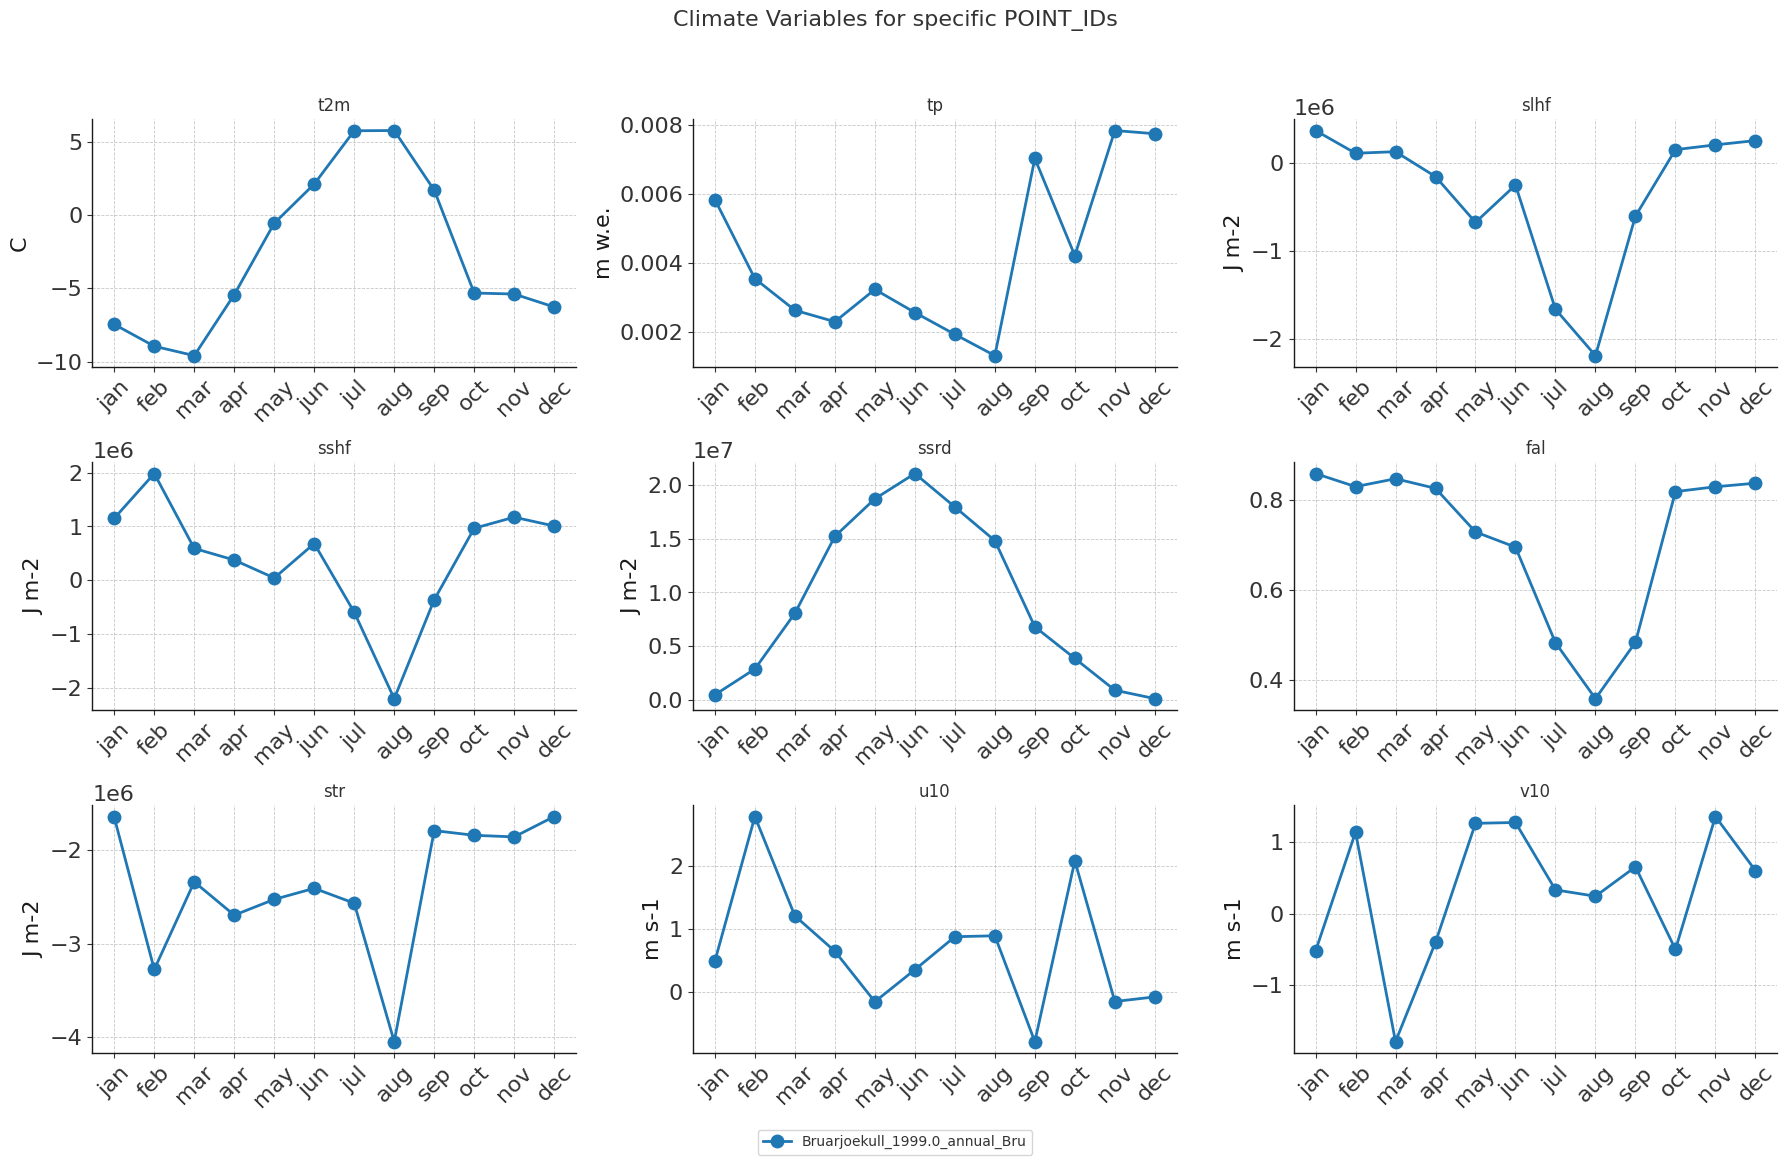

In [ ]:
# Search for points with large prediction errors
grouped_ids_test = grouped_ids.copy()
grouped_ids_test['pmb_diff'] = grouped_ids_test['target'] - grouped_ids_test['pred']
pd.set_option('display.max_colwidth', None)
display(grouped_ids_test[abs(grouped_ids_test['pmb_diff'] > 5)
])
pd.reset_option('display.max_colwidth')

# Plot climate variables for specific points
point_ids = ['Bruarjoekull_1999.0_annual_Bru']

plot_point_climate_variables(
    point_ids=point_ids,
    data_monthly=data_monthly_CH_ICE,
    vois_climate=vois_climate,
    vois_units=vois_units
)

### Predictions of custom parameters:

Shape of training dataset: (50663, 25)
Shape of testing dataset: (11419, 25)
Running with features: ['ELEVATION_DIFFERENCE', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'aspect', 'slope', 'consensus_ice_thickness', 'millan_v']
{'device': 'cuda:0', 'tree_method': 'hist', 'random_state': 30, 'n_jobs': 12, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}


Shape of the test: (11419, 14)
Overall score: 1.0213426540378856


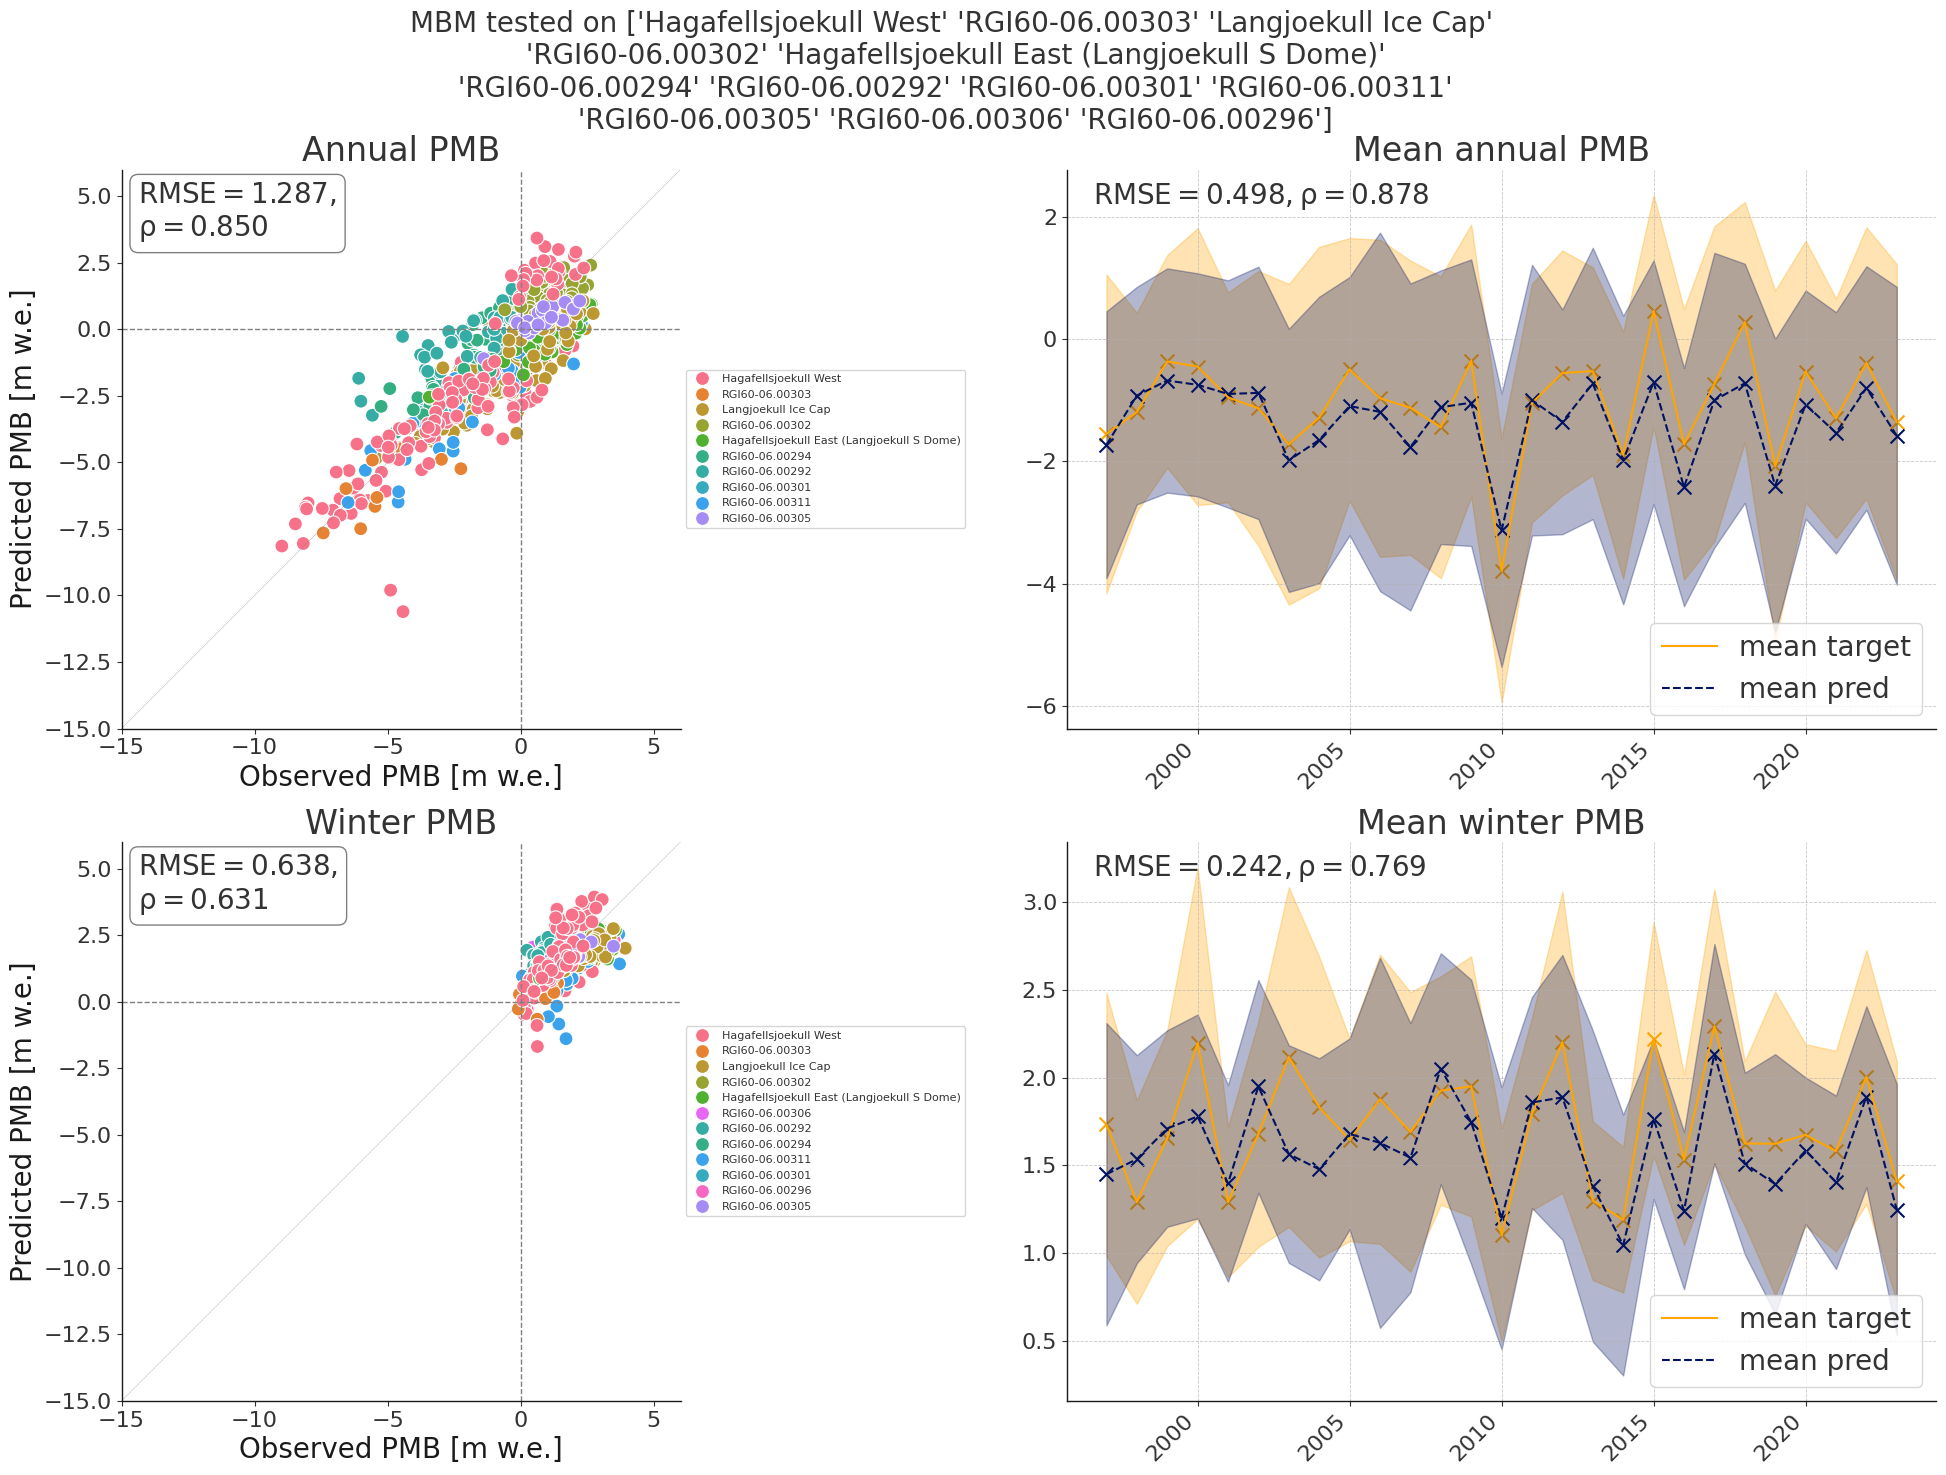

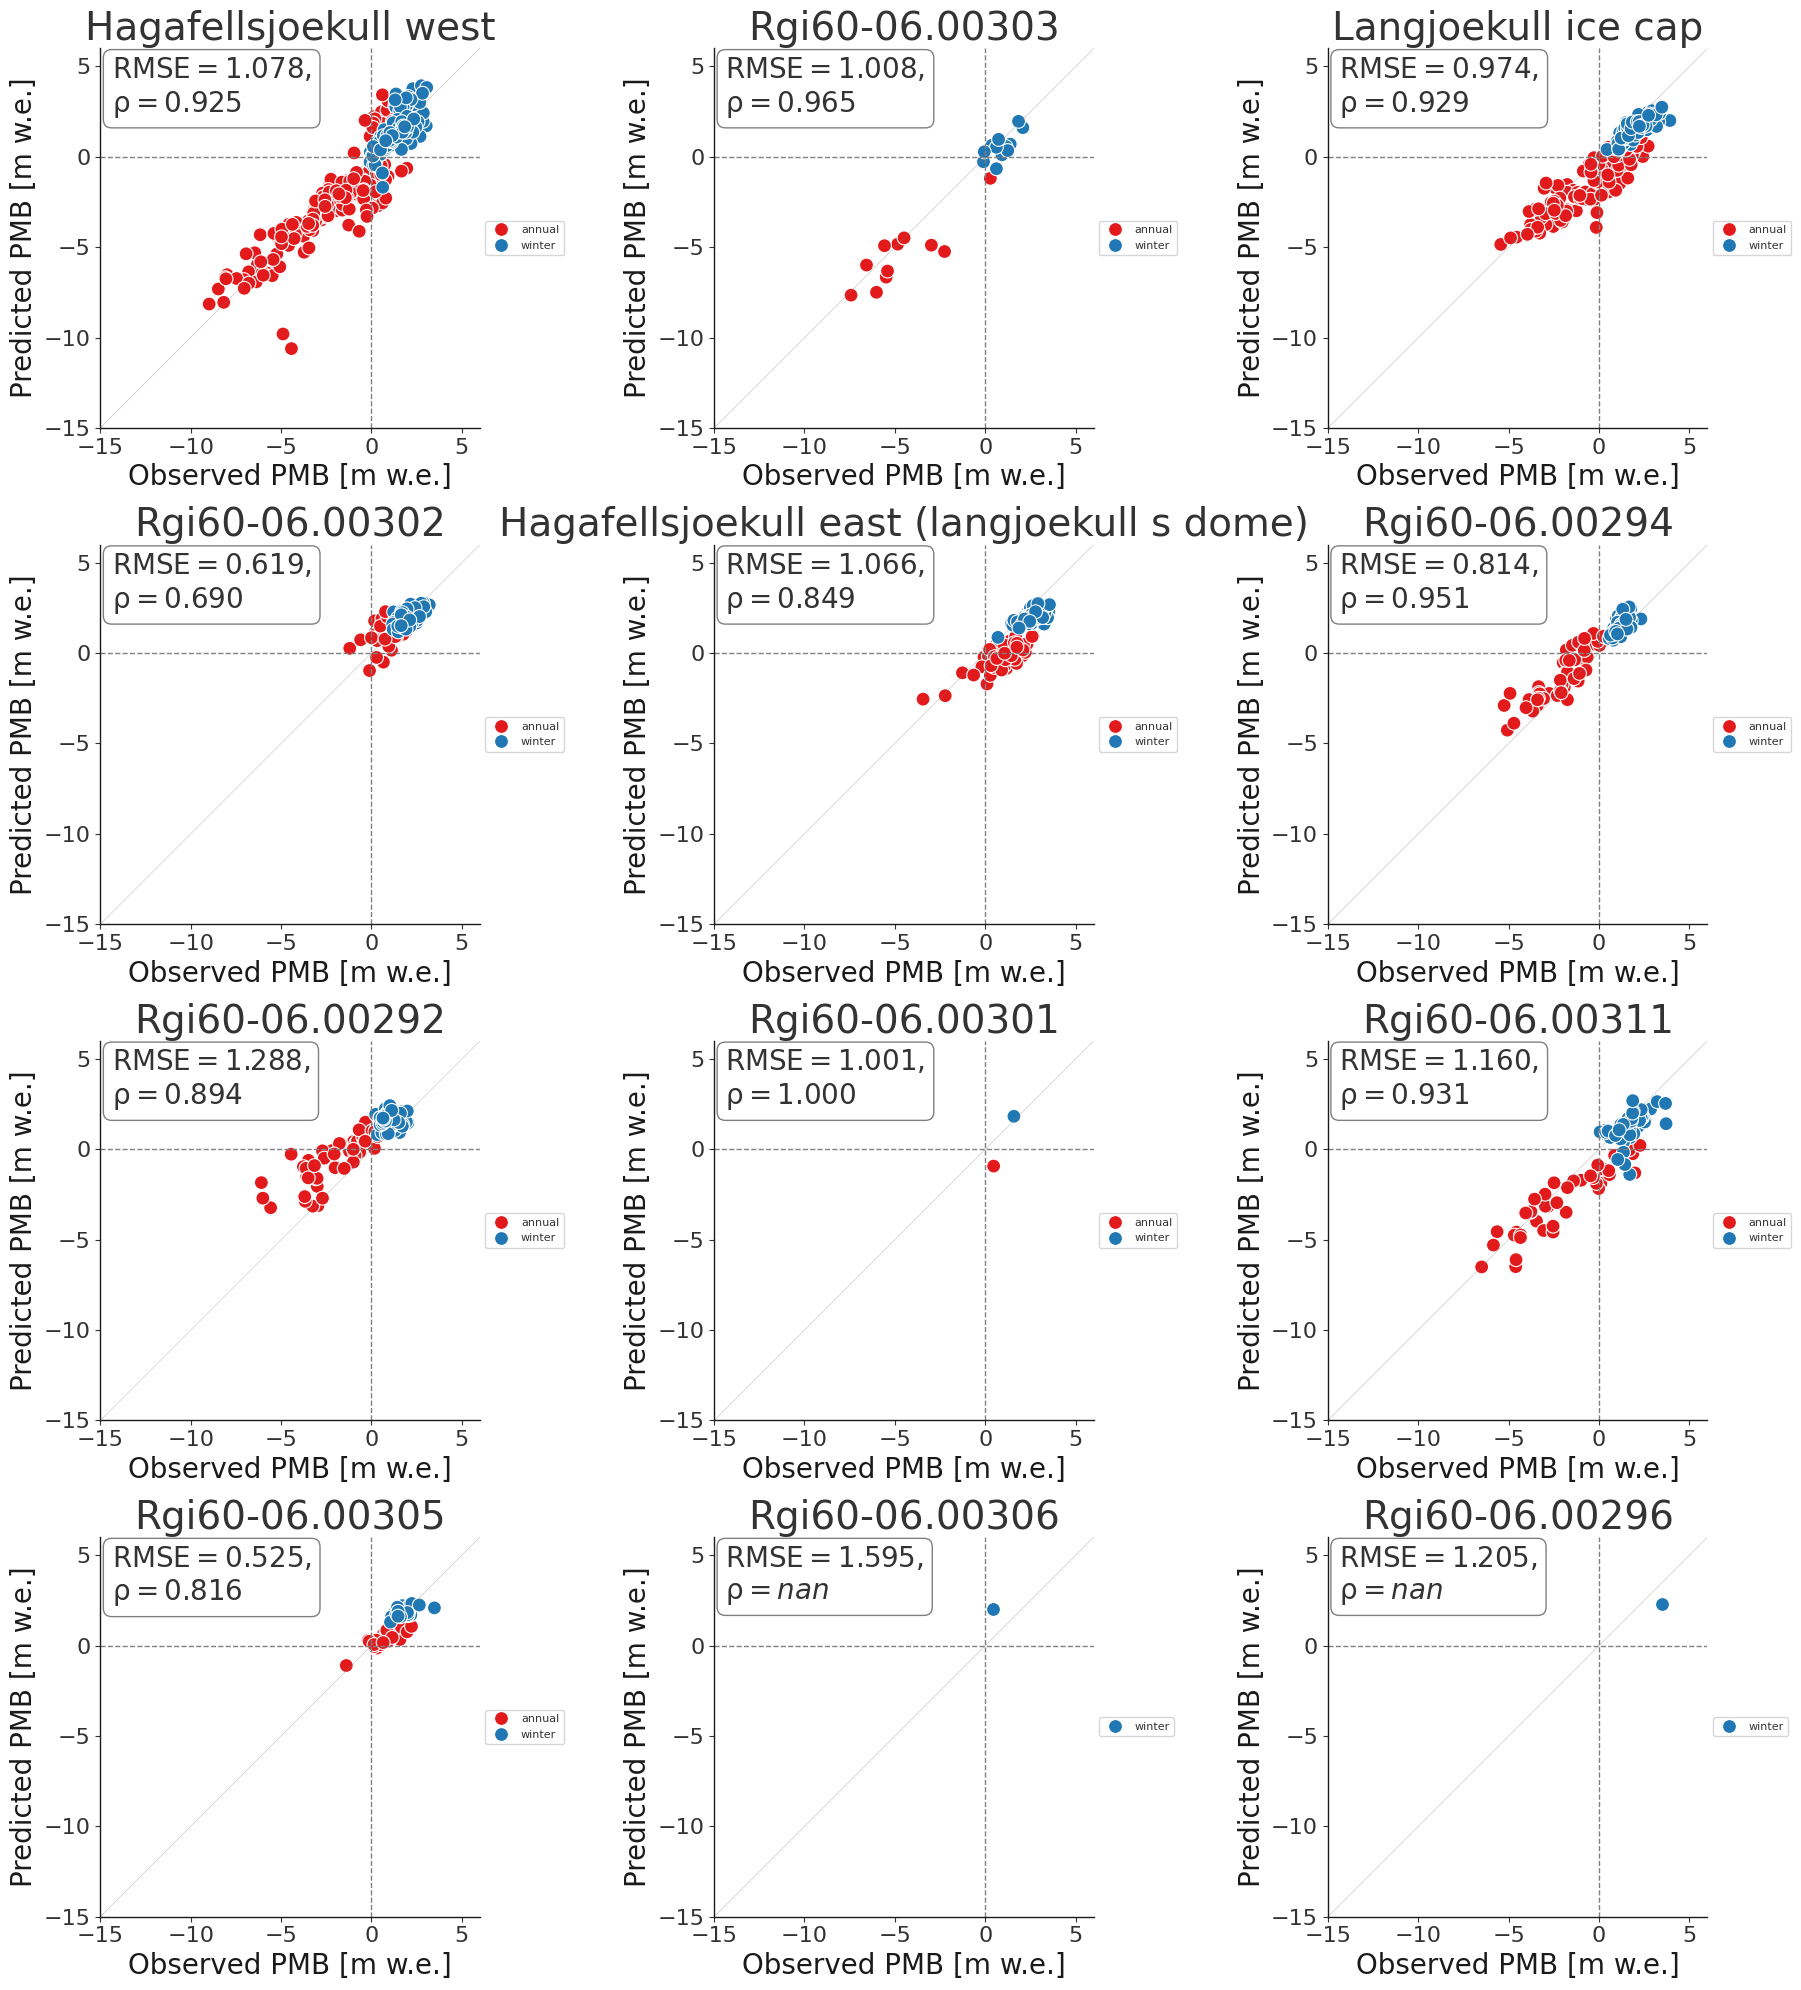

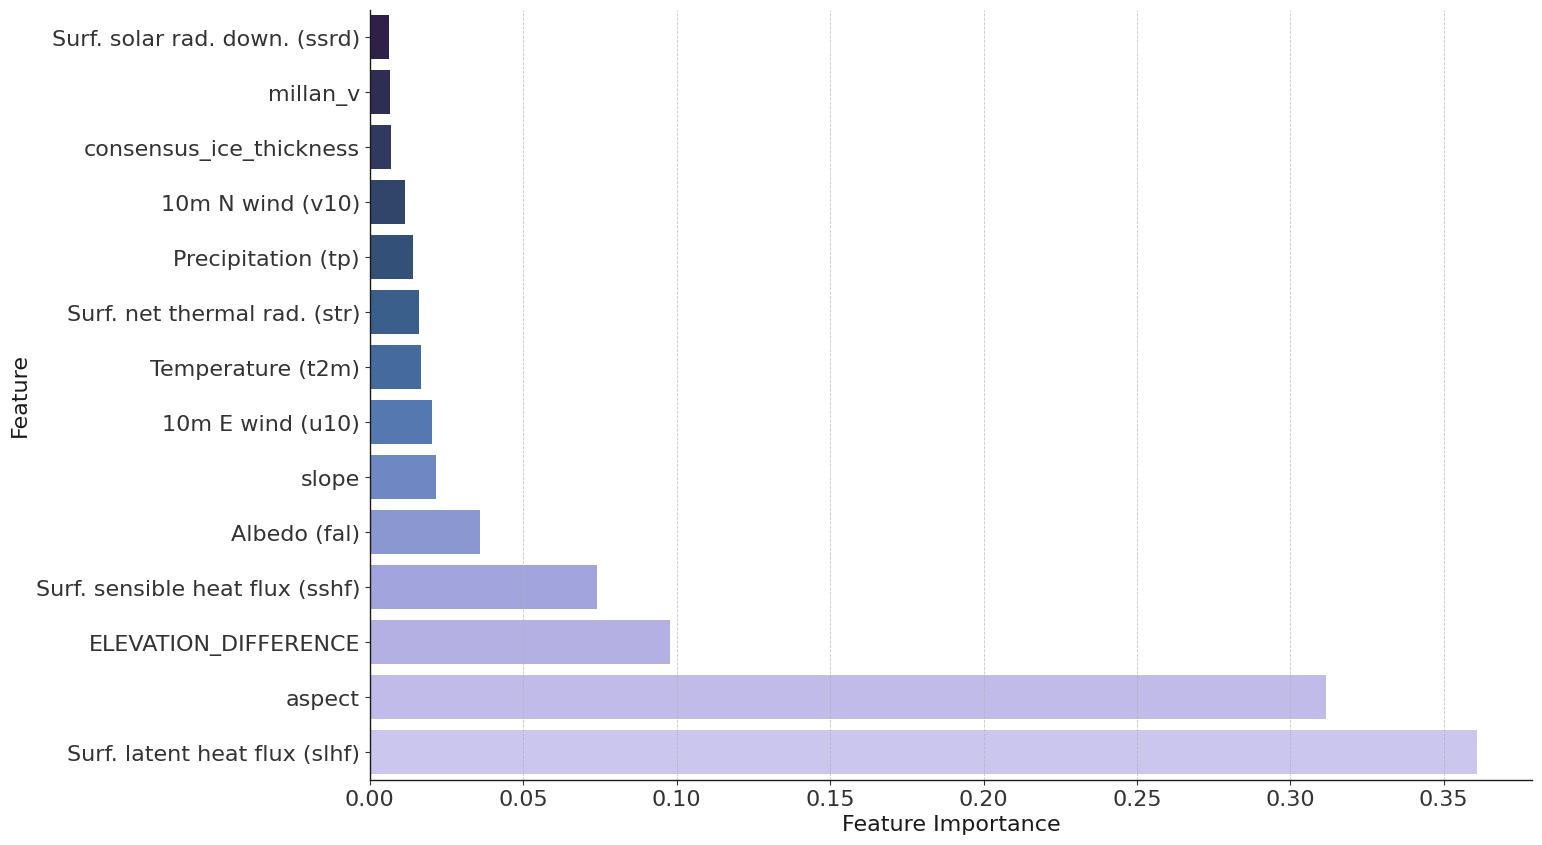

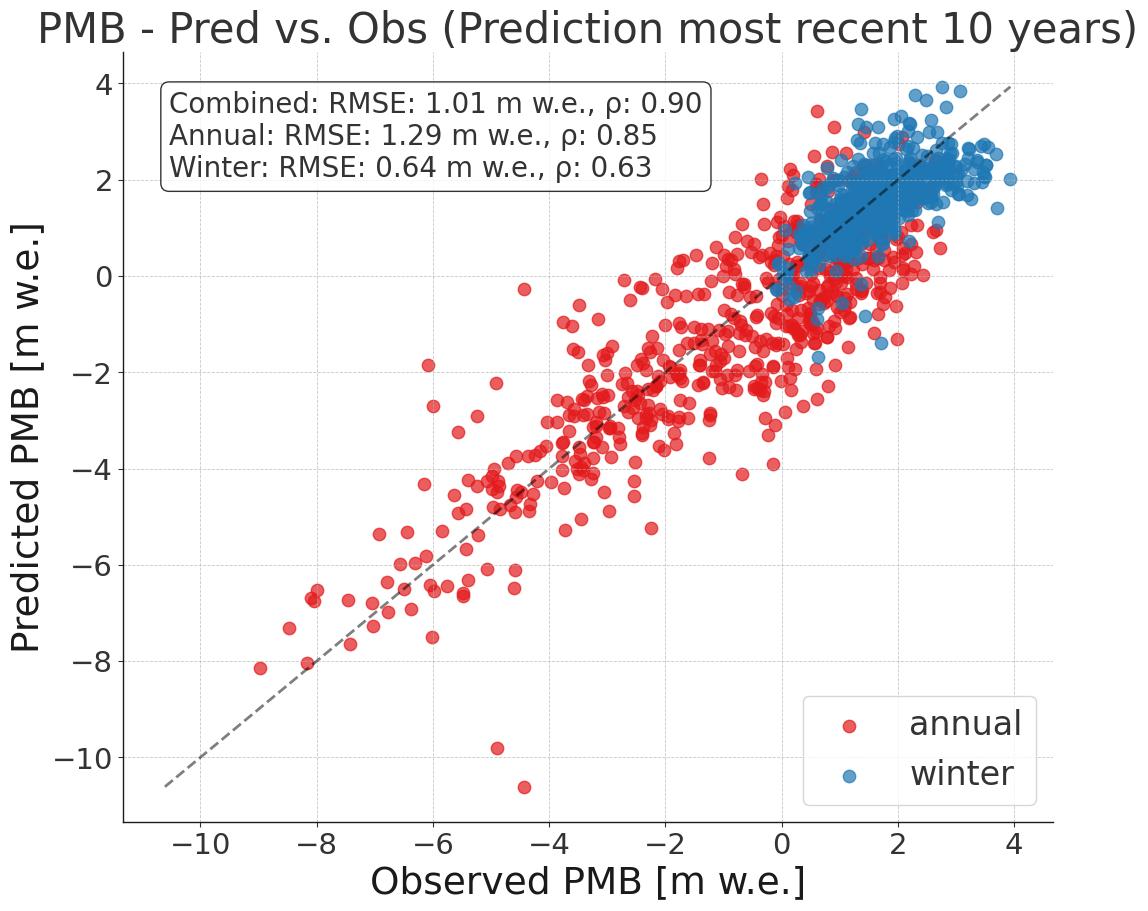

In [13]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

FIPlot(custom_model, feature_columns, vois_climate)

PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                custom_model, region_name='Prediction most recent 10 years', include_summer = False)